# Problem Set 4

**Task**: The problem set comprises one point only:

1.  Use Python to estimate the extent of triadic closure in a real-world, one-mode network.


**Context**:

- the Kossinets-Watts' model (see [week 4
  slideshow](https://github.com/simoneSantoni/net-analysis-smm638/blob/master/week4/slideshow_1.ipynb))
  offers the analytical framework to investigate triadic closure
- the key outcome of the submission is a chart that closely resembles what
  reported in the [week 4
  slideshow](https://github.com/simoneSantoni/net-analysis-smm638/blob/master/week4/slideshow_1.ipynb),
  "Triadic closure in an email exchange network" slide
- the email exchange dataset collected by the SNAP crowd is a suited setting to address the problem:
   * location: https://snap.stanford.edu/data/email-Eu-core-temporal.html
   * data come from a large European research institution. Here's a quote from the SNAP website: "We have anonymized information about all incoming and outgoing email between members of the research institution. The e-mails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world. A directed edge (u, v, t) means that person u sent an e-mail to person v at time t. A separate edge is created for each recipient of the e-mail. We also have four sub-networks corresponding to the communication between members of four different departments at the institution. Node IDs in the sub-networks do not correspond to the same node ID in the entire network."

**Submission**: Submit your solution via email to simone.santoni.1@city.ac.uk.
Late submissions (> November 18, 2020) may not be considered for the in-class
presentations.


 **Evaluating closure ― Kossinets & Watts' procedure**
We can address these questions empirically using network data as follows:

- We take two snapshots of the network at different times.
- For each $k$, we identify all pairs of nodes who have exactly $k$ friends in common in the first snapshot, but who are not directly connected by an edge
- We define $T(k)$ to be the fraction of these pairs that have formed an edge by the time of the second snapshot. This is our empirical estimate for the probability that a link will form between two people with $k$ friends in common.
- We plot $T(k)$ as a function of $k$ to illustrate the effect of common friends on the formation of links.

# Import relevant libraries

In [1]:
import math
import pprint
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# setup pprint
pp = pprint.PrettyPrinter(width=100, compact=True)

# remove false-positive warning (chain_assignment)
pd.set_option('mode.chained_assignment', None)

# Load dataset
Dataset used in this problem set is: ([email-Eu-core-temporal.txt.gz](https://snap.stanford.edu/data/email-Eu-core-temporal.txt.gz))  

Dataset info:
- Dataset statistics (email-Eu-core-temporal)
    - Nodes	986
    - Temporal Edges 332334
    - Edges in static graph	24929
    - Time span	803 days

In [3]:
data = pd.read_csv('email-Eu-core-temporal.txt', sep = ' ', names = ['source', 'target', 'timestamp'])
data

,source,target,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926
...,...,...,...
332329,324,367,45401817
332330,790,126,45402441
332331,790,126,45403709
332332,782,126,45404903


# Kossinets & Watts' procedure

# Pre-processing

## Step1:
- We take two snapshots of the network at different times.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332334 entries, 0 to 332333
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   source     332334 non-null  int64
 1   target     332334 non-null  int64
 2   timestamp  332334 non-null  int64
dtypes: int64(3)
memory usage: 7.6 MB


In [5]:
# before snapshot: at timestamp < 8640000 (100days) 
snap1 = data[data['timestamp'] < 8640000]

# sort by source, target
snap1.sort_values(by = ['source', 'target'], ascending = True, inplace = True)
snap1

,source,target,timestamp
49502,0,6,8167849
50211,0,6,8245817
1911,0,118,212684
49322,0,470,8157065
38823,0,732,6689158
...,...,...,...
37660,1004,977,5583912
42080,1004,977,7048494
48764,1004,977,8083620
49916,1004,977,8237184


In [6]:
# after snapshot: 200 days data (+100days from the first snap) 
snap2 = data[data['timestamp'] < 8640000*2]

# sort by source, target
snap2.sort_values(by = ['source', 'target'], ascending = True, inplace = True)
snap2

,source,target,timestamp
49502,0,6,8167849
50211,0,6,8245817
69562,0,6,11172035
74464,0,6,11777490
78755,0,6,12381593
...,...,...,...
92527,1004,977,14135391
103583,1004,977,15756668
103674,1004,977,15757958
105546,1004,977,15870940


## Step 2:
- For each $k$, we identify all pairs of nodes who have exactly $k$ friends in common in the first snapshot, but who are not directly connected by an edge

In [7]:
def kossinets_watts(snap):
    
    # get all nodes in the snap
    source_set = set(snap['source'])
    target_set = set(snap['target'])
    node_list = list(set(snap['source']).union(set(snap['target'])))

    # get dictionary of nodes (keys) and their ties (values)
    # {`node` : [list of nodes it has interacted with],...}
    structure = {}
    for node in node_list:
        if node in snap['source']:
            set1 = set(snap[snap['source'] == node]['target'].unique())
        if node in snap['target']:
            set2 = set(snap[snap['target'] == node]['source'].unique())
        to_append = list(set.union(set1, set2))
        structure[node] = to_append

    # preparation to create a nested dictionary
    nested_dict = {}

    # loop over all the nodes
    for source in node_list:
        temp_dict = {}
        for target in node_list:
            # to avoid duplicated data, only compute the cases where target > source
            if target > source:
                # if there is no edge between the two nodes
                if target not in structure[source]:
                    # calculate mutual ties
                    num_mutual = len(set.intersection(set(structure[source]), set(structure[target])))
                    # add the info to `temp_dict`
                    if num_mutual in temp_dict.keys():
                        temp_dict[num_mutual].append(target)
                    else: 
                        temp_dict[num_mutual] = [target]

        # store `temp_dict` in `nested_dict`            
        nested_dict[source] = temp_dict    
        
    return nested_dict, structure

In [8]:
# variable info:
# `result`: nested dict -> see above
# `structure`: {`node` : [list of nodes it has interacted with],...}
snap1_result, snap1_structure = kossinets_watts(snap1)
snap2_result, snap2_structure = kossinets_watts(snap2)

In [9]:
pp.pprint(snap1_structure)

{0: [32, 249, 6, 330, 333, 752, 118, 470, 790, 569, 732, 605],
 1: [323, 324, 548, 106, 303, 309, 310, 343],
 2: [769, 516, 782, 272, 17, 787, 532, 790, 283, 540, 38, 812, 814, 52, 313, 58, 61, 322, 66, 840,
     586, 75, 77, 846, 335, 849, 344, 602, 868, 112, 628, 629, 119, 891, 126, 389, 135, 664, 923,
     416, 167, 168, 700, 956, 969, 715, 465, 977, 983, 231, 236, 749, 499, 500, 248],
 4: [771, 135, 456, 585, 720, 405, 214, 159, 362, 304, 371, 441, 700],
 5: [772, 135, 275, 532, 670, 808, 553, 175, 78, 335, 724, 980, 732, 605, 607, 609, 362, 107, 491,
     246, 506, 381],
 6: [0, 772, 75, 333, 783, 470, 410, 732, 670, 159, 249, 1004, 881, 381, 189, 248, 569, 506, 61],
 7: [418],
 8: [544, 739, 422, 809, 143, 144, 563, 915, 696, 90, 731, 159],
 9: [166],
 10: [506, 381],
 11: [633, 923, 662, 617, 619, 334],
 12: [704, 422, 870, 680, 362, 720, 405, 406, 731],
 13: [704, 516, 837, 772, 14, 719, 783, 850, 532, 923, 738, 743, 682, 173, 239, 437, 506],
 14: [131, 516, 644, 650, 13, 270, 

       578, 581, 72, 586, 590, 591, 595, 607, 609, 612, 114, 116, 629, 638, 127, 135, 136, 647, 142,
       143, 147, 660, 659, 669, 157, 671, 160, 161, 167, 680, 687, 692, 693, 695, 188, 190, 703,
       704, 193, 200, 712, 713, 716, 718, 720, 209, 724, 214, 731, 220, 738, 739, 230, 742, 251,
       765, 769, 772, 776, 783, 272, 274, 787, 278, 283, 798, 802, 290, 809, 306, 307, 316, 833,
       324, 841, 844, 334, 851, 853, 343, 865, 866, 356, 359, 377, 891, 398, 912, 915, 406, 920,
       923, 927, 416, 935, 428, 940, 433, 951, 443, 450, 978, 987, 495, 500, 502, 506],
 160: [526, 530, 658, 915, 280, 24, 920, 543, 159, 428, 301, 685, 687, 561, 948, 53, 571, 202, 586,
       846, 591, 851, 214, 87, 857, 90, 858, 607, 360, 629, 630, 631, 891],
 161: [159, 193, 771, 936, 586, 239, 692, 214, 951, 890, 571, 863],
 164: [322, 649, 402, 788, 853, 223, 420, 548, 740, 103, 174, 879, 368, 638],
 165: [257, 647, 136, 264, 267, 141, 142, 17, 274, 401, 915, 920, 31, 543, 422, 552, 424, 683, 428,
 

       214, 343, 477, 612, 102, 362, 239, 369, 634, 125, 638],
 325: [186, 595, 863],
 326: [65, 772, 135, 587, 334, 720, 146, 930, 290, 483, 938, 687, 692, 120, 318, 191],
 327: [897, 849, 850, 275, 921, 737, 738, 175, 761, 506, 381, 702],
 329: [769, 65, 581, 582, 264, 334, 910, 338, 660, 789, 596, 540, 734, 248, 738, 997, 873, 427, 624,
       176, 692, 245, 310, 56, 764, 830],
 330: [0, 841],
 331: [418],
 332: [448, 782, 435, 500, 633, 250, 539, 700, 318],
 333: [0, 6, 710, 783, 16, 789, 470, 599, 409, 538, 29, 605, 862, 609, 228, 249, 743, 816, 693, 502,
       184, 569, 506, 767],
 334: [772, 776, 11, 530, 534, 542, 546, 38, 40, 569, 61, 65, 322, 324, 326, 329, 586, 75, 591, 90,
       607, 97, 609, 356, 612, 617, 107, 879, 628, 629, 120, 638, 383, 127, 134, 147, 915, 923, 157,
       670, 159, 671, 415, 416, 940, 687, 692, 185, 191, 462, 718, 214, 220, 995, 997, 742, 746,
       749, 245, 502, 248],
 335: [385, 2, 643, 898, 5, 532, 790, 664, 537, 29, 670, 808, 553, 810, 175, 68

 534: [772, 290, 546, 38, 550, 42, 562, 310, 61, 64, 65, 322, 324, 843, 334, 591, 84, 343, 90, 607,
       612, 102, 622, 879, 120, 890, 125, 638, 388, 135, 649, 139, 402, 663, 154, 159, 939, 174,
       692, 206, 477, 223, 735, 487, 489, 746, 749, 505, 510],
 535: [513, 772, 646, 542, 159, 927, 556, 684, 53, 823, 444, 62, 586, 75, 462, 722, 854, 472, 356,
       113, 369, 499, 500, 250, 124],
 537: [737, 107, 236, 335, 208, 532, 440, 506, 381],
 538: [333, 78, 239, 724, 693, 502, 951, 470, 569, 862],
 539: [332],
 540: [641, 2, 135, 789, 796, 925, 290, 546, 422, 432, 433, 692, 53, 311, 56, 696, 697, 698, 951,
       955, 830, 193, 68, 836, 581, 840, 329, 849, 338, 214, 855, 987, 731, 95, 736, 482, 483, 994,
       231, 361, 873, 364, 749, 242, 245, 633, 764, 511],
 541: [644, 14, 783, 16, 657, 921, 410, 923, 924, 808, 173, 685, 433, 307, 951, 576, 199, 586, 977,
       850, 90, 738, 996, 752, 881, 506, 381],
 542: [513, 772, 517, 646, 136, 528, 530, 915, 535, 923, 157, 670, 159, 927, 

       198, 714, 75, 591, 466, 596, 214, 90, 607, 488, 379, 380],
 713: [707, 454, 268, 592, 159, 927, 98, 291, 107, 566],
 714: [193, 712, 617, 890],
 715: [2, 933, 171, 347, 147, 308, 277, 951, 923, 926],
 716: [777, 522, 16, 19, 915, 149, 410, 158, 31, 159, 32, 167, 423, 428, 700, 189, 61, 457, 718,
       851, 724, 597, 980, 607, 609, 866, 249, 236, 365, 876, 1004, 883, 118, 377, 122, 890, 127],
 718: [772, 775, 777, 522, 783, 16, 530, 275, 280, 542, 31, 32, 290, 292, 293, 48, 569, 61, 65, 586,
       843, 334, 591, 593, 595, 851, 90, 607, 866, 356, 101, 362, 107, 365, 114, 883, 629, 118, 120,
       377, 122, 127, 135, 904, 141, 915, 404, 916, 659, 920, 410, 157, 670, 159, 167, 423, 681,
       684, 687, 692, 189, 450, 708, 197, 711, 201, 457, 969, 716, 462, 464, 720, 977, 724, 980,
       732, 991, 746, 749, 754, 243, 246, 502, 248, 506],
 719: [837, 13, 14, 783, 16, 850, 410, 923, 158, 738, 682, 56, 761, 506],
 720: [4, 772, 135, 12, 415, 159, 927, 290, 680, 936, 170, 942, 304, 

 948: [517, 392, 267, 927, 416, 160, 674, 803, 290, 165, 168, 52, 313, 191, 65, 586, 75, 459, 592,
       859, 232, 112, 499, 500, 629, 120, 890, 126],
 950: [832, 514, 323, 780, 399, 337, 788, 663, 343, 420, 740, 102, 103, 106, 303, 368, 509],
 951: [769, 772, 267, 273, 538, 540, 541, 798, 31, 546, 35, 552, 809, 306, 569, 58, 324, 581, 78,
       338, 595, 341, 857, 603, 605, 609, 865, 866, 103, 369, 377, 890, 638, 388, 142, 915, 660,
       923, 159, 927, 161, 424, 170, 171, 433, 435, 692, 189, 703, 194, 706, 707, 711, 200, 203,
       715, 971, 976, 979, 724, 214, 727, 731, 482, 738, 235, 239, 500, 245, 502, 506],
 952: [517, 838, 200, 971, 142, 847, 915, 344, 857, 543, 165, 428, 630, 316],
 953: [838, 647, 200, 142, 207, 847, 658, 915, 280, 24, 857, 92, 165, 424, 362, 428, 374, 569, 316],
 954: [547, 167, 552, 207, 847, 978, 469, 630, 280],
 955: [773, 582, 231, 873, 427, 789, 311, 987, 540, 925, 510],
 956: [2, 790, 25, 672, 41, 684, 558, 48, 565, 700, 319, 704, 193, 321, 73, 458,

In [10]:
pp.pprint(snap1_result)

{0: {0: [1, 4, 7, 8, 9, 10, 11, 12, 13, 15, 23, 25, 26, 27, 28, 30, 34, 35, 36, 39, 41, 42, 44, 46,
         49, 50, 56, 58, 59, 60, 62, 64, 67, 68, 69, 71, 72, 73, 74, 76, 77, 79, 82, 83, 84, 86, 87,
         91, 92, 95, 96, 97, 98, 101, 102, 103, 104, 105, 106, 110, 111, 112, 113, 114, 115, 116,
         117, 122, 124, 125, 131, 132, 133, 134, 136, 137, 138, 139, 141, 142, 144, 145, 146, 147,
         148, 150, 151, 152, 153, 154, 157, 160, 161, 164, 165, 166, 167, 171, 173, 174, 175, 176,
         179, 180, 181, 186, 187, 190, 192, 194, 195, 198, 199, 200, 201, 202, 203, 205, 206, 207,
         208, 209, 215, 216, 217, 218, 219, 221, 223, 227, 230, 232, 239, 240, 241, 242, 243, 245,
         246, 250, 251, 252, 254, 255, 256, 257, 259, 263, 264, 268, 269, 270, 272, 273, 274, 275,
         276, 277, 283, 284, 285, 291, 292, 297, 299, 301, 302, 303, 304, 305, 307, 308, 309, 310,
         311, 313, 316, 317, 319, 320, 321, 323, 324, 325, 326, 327, 329, 331, 332, 337, 338, 341,
        

         101, 103, 105, 113, 115, 117, 124, 131, 132, 138, 143, 144, 145, 146, 148, 150, 154, 174,
         179, 180, 186, 194, 195, 198, 203, 206, 215, 217, 218, 219, 221, 226, 230, 240, 241, 243,
         246, 251, 252, 254, 255, 257, 259, 263, 268, 269, 273, 276, 281, 284, 285, 291, 295, 297,
         302, 303, 304, 317, 320, 325, 330, 331, 333, 339, 346, 355, 368, 370, 372, 374, 375, 378,
         382, 386, 391, 394, 395, 396, 397, 401, 402, 404, 406, 407, 408, 411, 426, 429, 430, 431,
         434, 436, 438, 441, 442, 452, 453, 456, 461, 467, 470, 471, 473, 474, 478, 481, 485, 487,
         488, 489, 495, 501, 504, 505, 508, 513, 520, 523, 524, 527, 533, 538, 539, 544, 549, 551,
         554, 559, 562, 563, 564, 566, 571, 574, 576, 578, 580, 584, 588, 589, 590, 593, 596, 597,
         603, 606, 613, 616, 619, 626, 627, 634, 637, 639, 645, 647, 649, 652, 653, 654, 657, 669,
         671, 673, 676, 678, 681, 682, 683, 686, 693, 694, 695, 699, 701, 708, 709, 710, 713, 714,
         7

     5: [6, 61, 65, 118, 184, 189, 192, 236, 248, 334, 450, 537, 643, 742, 898, 915, 921, 923],
     6: [75, 120, 159, 201, 528, 850, 951, 1001, 1004],
     7: [127, 377, 502, 687, 783],
     8: [90, 688],
     9: [569],
     10: [29],
     12: [718]},
 6: {0: [7, 9, 11, 12, 15, 17, 23, 25, 26, 27, 28, 30, 34, 35, 36, 39, 41, 42, 44, 45, 46, 48, 50,
         52, 58, 59, 60, 64, 66, 67, 69, 71, 73, 74, 76, 77, 79, 83, 84, 86, 87, 92, 95, 96, 97, 98,
         101, 102, 103, 104, 105, 106, 110, 111, 112, 113, 115, 117, 119, 124, 125, 126, 132, 133,
         134, 137, 138, 139, 141, 144, 145, 146, 148, 149, 151, 152, 154, 164, 168, 170, 171, 174,
         176, 179, 180, 187, 194, 195, 197, 198, 202, 203, 205, 206, 207, 215, 216, 217, 219, 221,
         227, 232, 240, 241, 242, 245, 246, 250, 253, 254, 255, 256, 259, 260, 263, 264, 267, 268,
         269, 273, 275, 276, 277, 284, 285, 291, 294, 297, 299, 301, 302, 303, 304, 305, 308, 309,
         310, 311, 313, 317, 318, 319, 321, 322, 323

         171, 174, 176, 179, 180, 181, 184, 186, 187, 192, 194, 195, 196, 197, 198, 202, 203, 206,
         207, 208, 215, 217, 218, 219, 221, 227, 228, 229, 231, 232, 235, 240, 241, 242, 243, 245,
         246, 249, 250, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 269, 273, 275, 276,
         277, 291, 293, 294, 295, 297, 299, 301, 303, 304, 305, 308, 309, 310, 311, 313, 317, 318,
         319, 320, 321, 322, 323, 325, 326, 327, 329, 330, 331, 332, 333, 335, 337, 338, 339, 341,
         346, 350, 353, 355, 365, 366, 368, 369, 370, 372, 373, 374, 375, 378, 379, 380, 382, 383,
         385, 386, 389, 391, 392, 393, 394, 395, 396, 397, 399, 400, 401, 402, 404, 405, 407, 408,
         409, 410, 411, 414, 415, 418, 420, 421, 424, 426, 427, 429, 430, 431, 432, 434, 435, 436,
         437, 438, 439, 440, 441, 442, 444, 446, 447, 448, 449, 452, 453, 456, 458, 459, 460, 461,
         465, 466, 467, 468, 469, 470, 471, 473, 474, 475, 476, 477, 478, 481, 482, 487, 488, 489,
         4

          448, 449, 450, 452, 453, 454, 456, 457, 458, 459, 460, 462, 464, 465, 466, 467, 468, 469,
          470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 492,
          493, 495, 497, 499, 500, 501, 502, 504, 505, 509, 510, 511, 512, 513, 514, 515, 517, 519,
          520, 522, 523, 524, 526, 527, 528, 530, 531, 533, 534, 535, 538, 539, 540, 542, 543, 544,
          546, 547, 548, 549, 550, 551, 552, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566,
          568, 569, 571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589,
          590, 591, 592, 593, 594, 595, 596, 597, 602, 603, 606, 607, 609, 612, 613, 614, 616, 617,
          618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 645,
          646, 647, 648, 649, 652, 655, 656, 658, 659, 660, 661, 662, 663, 664, 669, 671, 672, 673,
          674, 676, 678, 679, 680, 681, 683, 684, 685, 686, 687, 693, 694, 695, 696, 697, 698, 699,


          727, 729, 732, 734, 735, 736, 737, 738, 740, 741, 742, 745, 747, 748, 749, 752, 753, 754,
          758, 759, 761, 762, 763, 764, 767, 769, 770, 773, 774, 775, 776, 777, 779, 780, 782, 783,
          784, 787, 788, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 810, 812, 814,
          815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 834, 835, 836,
          837, 838, 840, 841, 842, 843, 845, 846, 847, 849, 850, 852, 853, 857, 858, 859, 861, 862,
          865, 866, 867, 868, 869, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885,
          886, 887, 889, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 910, 911, 912, 916,
          918, 921, 923, 924, 925, 926, 930, 931, 933, 934, 935, 938, 939, 940, 944, 945, 947, 948,
          950, 952, 954, 955, 958, 960, 963, 966, 967, 968, 969, 970, 972, 973, 975, 976, 977, 979,
          983, 985, 986, 987, 988, 991, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
      1: [13, 2

          511, 512, 513, 514, 515, 519, 520, 523, 524, 526, 527, 528, 531, 533, 535, 539, 540, 543,
          544, 547, 548, 549, 551, 552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566,
          571, 573, 574, 575, 577, 578, 580, 584, 587, 588, 589, 592, 594, 596, 603, 606, 612, 614,
          616, 618, 619, 622, 624, 626, 627, 628, 630, 631, 633, 634, 637, 639, 640, 641, 645, 646,
          647, 648, 649, 655, 656, 658, 660, 661, 664, 669, 671, 672, 673, 676, 678, 679, 680, 683,
          686, 694, 695, 697, 698, 699, 701, 703, 704, 705, 706, 707, 709, 713, 714, 715, 722, 723,
          727, 729, 734, 735, 736, 737, 739, 740, 741, 748, 753, 758, 759, 763, 764, 765, 770, 771,
          773, 774, 780, 782, 784, 787, 788, 791, 793, 794, 795, 798, 800, 801, 803, 804, 807, 809,
          810, 812, 814, 815, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833,
          834, 836, 838, 841, 842, 844, 845, 846, 847, 852, 853, 855, 857, 858, 859, 861, 863, 865,


          487, 488, 489, 492, 495, 499, 500, 501, 504, 505, 508, 509, 510, 511, 513, 514, 515, 516,
          519, 522, 523, 524, 527, 531, 532, 533, 534, 535, 537, 539, 548, 549, 551, 553, 554, 556,
          557, 559, 562, 564, 565, 573, 574, 575, 578, 581, 582, 588, 589, 590, 592, 593, 594, 597,
          603, 606, 612, 613, 616, 617, 618, 619, 622, 624, 626, 627, 628, 634, 637, 638, 639, 640,
          641, 644, 645, 646, 649, 650, 653, 654, 655, 657, 659, 660, 661, 663, 664, 671, 672, 673,
          676, 679, 681, 682, 683, 686, 688, 694, 698, 699, 701, 702, 703, 704, 705, 706, 708, 711,
          713, 714, 715, 719, 723, 727, 729, 732, 734, 735, 736, 737, 738, 740, 741, 743, 745, 747,
          748, 752, 753, 758, 759, 761, 763, 764, 765, 767, 769, 770, 771, 773, 774, 779, 780, 782,
          783, 784, 787, 788, 793, 794, 798, 800, 801, 804, 807, 808, 810, 812, 814, 815, 816, 818,
          819, 820, 821, 822, 823, 828, 829, 830, 832, 833, 834, 835, 836, 837, 841, 842, 844, 845,


          492, 493, 495, 497, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515,
          516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 532, 533, 534, 535, 537, 538,
          539, 540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 558,
          559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 578, 580, 581,
          582, 584, 585, 586, 587, 588, 589, 591, 592, 593, 594, 595, 596, 597, 599, 602, 603, 605,
          606, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 630, 631, 633, 634,
          637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656,
          657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 674, 676, 678, 679, 680, 681,
          682, 683, 684, 685, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702,
          703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 716, 718, 719, 720, 722, 723,


          79, 83, 84, 86, 87, 92, 95, 96, 98, 101, 102, 103, 105, 113, 114, 115, 116, 117, 118, 119,
          125, 127, 131, 132, 136, 138, 139, 141, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153,
          154, 158, 164, 165, 171, 174, 175, 179, 180, 181, 184, 188, 190, 192, 194, 195, 198, 202,
          203, 206, 207, 208, 215, 217, 218, 219, 221, 227, 228, 229, 230, 235, 239, 241, 242, 243,
          245, 246, 249, 250, 251, 252, 253, 254, 255, 257, 259, 263, 269, 272, 273, 274, 275, 276,
          277, 278, 281, 283, 284, 285, 291, 293, 295, 297, 299, 301, 302, 303, 304, 307, 308, 309,
          310, 311, 316, 317, 318, 319, 320, 321, 322, 323, 325, 327, 330, 331, 332, 335, 339, 343,
          344, 346, 350, 355, 359, 365, 366, 368, 370, 372, 373, 374, 375, 378, 379, 380, 382, 385,
          386, 389, 391, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404, 406, 407, 408, 409,
          410, 411, 414, 418, 420, 421, 423, 424, 426, 427, 429, 430, 431, 432, 434, 436, 437, 438,

      4: [53, 92, 118, 149, 200, 201, 207, 228, 246, 278, 316, 324, 338, 443, 500, 531, 534, 538,
          541, 585, 685, 696, 710, 732, 738, 765, 802, 809, 844, 857, 904, 907, 912, 935, 976, 978,
          994, 1001],
      5: [114, 136, 188, 239, 267, 423, 457, 469, 526, 528, 561, 599, 656, 684, 776, 790, 953, 969,
          990, 1004],
      6: [40, 122, 141, 231, 272, 493, 540, 542, 546, 631, 712, 742, 749, 866, 980],
      7: [56, 75, 142, 274, 281, 360, 362, 422, 544, 586, 647, 783, 890],
      8: [107, 157, 193, 333, 506, 630, 658, 670, 720, 923],
      9: [167, 248, 356, 450, 470, 951, 987],
      10: [595, 605, 609, 692, 724],
      11: [377, 462],
      12: [120, 135, 334, 410, 746],
      13: [160, 629],
      15: [65],
      16: [290, 772],
      18: [61, 607]},
 34: {0: [35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 52, 58, 59, 60, 62, 64, 66, 67, 68,
          69, 71, 73, 74, 76, 77, 78, 79, 83, 84, 86, 87, 91, 92, 96, 98, 101, 102, 103, 104, 105,
          106, 10

          842, 843, 844, 845, 846, 847, 849, 852, 853, 855, 857, 858, 859, 861, 862, 863, 866, 867,
          868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887,
          889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 916,
          918, 921, 922, 924, 925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 942, 944, 945, 946,
          947, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971,
          972, 973, 975, 976, 977, 979, 983, 984, 985, 986, 988, 990, 991, 993, 994, 995, 996, 1001,
          1002, 1003, 1004],
      1: [53, 58, 61, 65, 72, 75, 91, 107, 127, 135, 141, 147, 157, 166, 190, 191, 193, 196, 198,
          201, 214, 220, 223, 226, 233, 248, 268, 278, 291, 292, 305, 326, 334, 356, 388, 416, 433,
          454, 499, 502, 517, 528, 530, 534, 542, 546, 566, 569, 586, 607, 609, 612, 629, 633, 684,
          687, 718, 739, 743, 752, 765, 769, 772, 776, 783, 812, 834, 85

          146, 148, 153, 154, 158, 164, 170, 174, 175, 176, 179, 180, 186, 192, 194, 195, 202, 203,
          206, 207, 208, 215, 217, 219, 221, 227, 232, 240, 241, 242, 252, 259, 260, 263, 269, 273,
          275, 276, 284, 294, 301, 302, 303, 304, 309, 310, 313, 320, 323, 325, 327, 330, 331, 335,
          341, 344, 346, 350, 353, 355, 365, 366, 368, 370, 373, 374, 375, 378, 382, 385, 386, 389,
          391, 393, 394, 395, 396, 399, 400, 402, 404, 405, 407, 408, 411, 414, 418, 420, 421, 424,
          426, 431, 432, 434, 436, 437, 438, 439, 440, 441, 442, 446, 447, 448, 449, 453, 456, 460,
          461, 465, 467, 468, 469, 472, 473, 474, 475, 476, 477, 478, 481, 487, 489, 492, 497, 505,
          508, 510, 512, 514, 516, 519, 520, 524, 527, 532, 533, 537, 539, 547, 548, 549, 552, 554,
          556, 559, 562, 563, 564, 574, 575, 582, 584, 588, 593, 597, 603, 606, 616, 619, 622, 624,
          626, 634, 639, 640, 643, 645, 649, 652, 653, 654, 655, 656, 658, 661, 664, 673, 676, 681,


          277, 280, 281, 283, 284, 285, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305,
          306, 307, 308, 309, 310, 311, 313, 316, 317, 320, 322, 323, 324, 325, 326, 327, 329, 330,
          331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 359, 360,
          361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380, 381,
          382, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404,
          405, 406, 407, 408, 409, 410, 411, 414, 416, 418, 420, 421, 422, 423, 424, 426, 427, 428,
          429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 446, 447,
          448, 449, 450, 452, 453, 456, 457, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470,
          471, 472, 473, 474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492,
          493, 495, 497, 500, 501, 502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515, 516,


          842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 854, 855, 857, 858, 859, 861, 862, 863,
          865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 880, 881, 882, 883, 884, 885,
          886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911,
          912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936,
          938, 940, 942, 944, 945, 946, 947, 948, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963,
          966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986,
          987, 988, 990, 991, 993, 994, 995, 996, 997, 1002, 1003, 1004],
      1: [64, 69, 103, 139, 174, 323, 324, 334, 388, 477, 534, 591, 603, 649, 706, 740, 752, 832,
          939, 1001],
      2: [102, 106, 125, 164, 223, 299, 310, 337, 368, 420, 509, 510, 514, 622, 638, 663, 780, 950],
      3: [343, 853, 879],
      4: [788]},
 48: {0: [49, 50, 58, 59, 60, 62, 64, 67, 68, 69, 71, 72, 74, 

          200, 202, 203, 205, 206, 207, 208, 215, 216, 217, 218, 219, 221, 223, 226, 228, 230, 233,
          235, 239, 241, 242, 245, 246, 249, 250, 251, 252, 254, 255, 257, 259, 263, 264, 268, 269,
          270, 273, 274, 275, 276, 277, 281, 284, 285, 291, 293, 295, 297, 299, 301, 302, 303, 304,
          307, 308, 309, 310, 311, 316, 317, 318, 319, 320, 321, 323, 325, 327, 330, 331, 332, 333,
          337, 339, 341, 343, 346, 350, 353, 355, 359, 360, 361, 364, 365, 366, 368, 370, 371, 372,
          373, 374, 375, 378, 379, 380, 381, 382, 385, 386, 391, 393, 394, 395, 396, 397, 398, 399,
          400, 401, 402, 404, 405, 406, 407, 408, 409, 411, 414, 418, 420, 421, 422, 423, 424, 426,
          427, 428, 429, 430, 431, 432, 433, 434, 436, 437, 438, 440, 441, 442, 444, 446, 448, 452,
          453, 456, 457, 460, 461, 464, 466, 467, 468, 469, 470, 471, 473, 474, 475, 476, 477, 478,
          479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 501, 504, 506, 508, 509,


          302, 307, 324, 333, 362, 371, 381, 398, 406, 435, 457, 471, 553, 563, 566, 588, 590, 593,
          605, 650, 658, 659, 663, 669, 680, 693, 695, 703, 707, 710, 754, 777, 784, 833, 837, 841,
          844, 855, 872, 907, 926, 948, 952, 953, 963, 977, 983, 990, 1001],
      3: [92, 142, 161, 165, 166, 191, 230, 239, 264, 268, 305, 316, 343, 361, 422, 428, 432, 500,
          506, 511, 528, 535, 572, 592, 613, 614, 638, 647, 696, 712, 724, 736, 738, 752, 843, 857,
          863, 866, 870, 901, 935, 955, 978, 993],
      4: [68, 107, 136, 147, 185, 272, 470, 544, 550, 582, 612, 617, 624, 670, 671, 700, 716, 743,
          765, 812, 836, 840, 849, 865, 873, 890, 891, 912, 980],
      5: [160, 176, 311, 443, 454, 546, 595, 660, 684, 764, 769, 809, 830, 834, 910],
      6: [95, 190, 233, 245, 278, 280, 326, 415, 462, 499, 581, 850],
      7: [231, 251, 306, 364, 377, 416, 433, 517, 586, 720, 775, 783, 927, 940, 997],
      8: [220, 338, 530, 534, 739, 951],
      9: [61, 127, 356, 4

          397, 399, 404, 405, 406, 407, 408, 430, 435, 436, 438, 452, 477, 478, 487, 489, 491, 493,
          501, 509, 510, 511, 513, 533, 538, 557, 561, 562, 564, 574, 589, 594, 597, 599, 622, 624,
          631, 637, 646, 649, 650, 652, 654, 657, 661, 664, 669, 678, 680, 681, 685, 686, 698, 702,
          705, 706, 708, 713, 719, 722, 729, 740, 748, 764, 779, 791, 794, 796, 808, 809, 814, 832,
          836, 846, 847, 852, 855, 859, 867, 876, 877, 882, 884, 887, 896, 898, 909, 921, 925, 931,
          933, 936, 945, 950, 963, 970, 972, 973, 988, 995, 1003],
      2: [77, 82, 83, 92, 95, 97, 116, 119, 124, 137, 141, 255, 264, 291, 299, 302, 310, 311, 313,
          317, 320, 333, 344, 347, 369, 392, 400, 402, 422, 449, 459, 465, 469, 471, 495, 516, 526,
          532, 541, 543, 553, 565, 577, 578, 614, 644, 658, 707, 715, 735, 736, 761, 763, 773, 789,
          803, 822, 823, 837, 838, 845, 880, 881, 885, 916, 922, 924, 942, 953, 971, 984, 990, 994,
          996],
      3: [62, 84, 

          916, 918, 920, 921, 922, 923, 924, 925, 926, 930, 931, 933, 934, 935, 936, 938, 940, 942,
          944, 945, 946, 947, 948, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968,
          970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991,
          993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
      1: [65, 75, 84, 96, 103, 132, 135, 154, 164, 174, 193, 206, 239, 303, 399, 415, 420, 487, 489,
          505, 514, 546, 548, 550, 562, 633, 649, 692, 706, 735, 746, 749, 772, 780, 843, 853, 890,
          893, 927, 950, 969],
      2: [90, 102, 106, 120, 139, 159, 223, 290, 299, 310, 323, 337, 402, 477, 510, 591, 607, 622,
          634, 740, 752, 788, 832, 939],
      3: [125, 324, 334, 343, 638, 879],
      4: [388, 663]},
 65: {0: [69, 71, 76, 87, 103, 106, 110, 132, 138, 144, 145, 153, 164, 179, 180, 195, 203, 215, 217,
          219, 227, 240, 242, 251, 252, 255, 263, 269, 273, 276, 283, 297, 299, 303, 309, 323, 330,
    

          380, 398, 404, 409, 414, 415, 416, 437, 440, 442, 443, 450, 452, 454, 461, 470, 471, 483,
          491, 501, 502, 508, 516, 517, 522, 528, 532, 534, 535, 537, 541, 542, 544, 566, 569, 573,
          576, 586, 591, 599, 609, 613, 629, 637, 643, 644, 650, 653, 654, 657, 660, 670, 682, 684,
          687, 688, 696, 697, 698, 702, 703, 704, 719, 720, 724, 736, 738, 739, 742, 743, 745, 747,
          752, 754, 761, 775, 776, 808, 812, 822, 823, 830, 833, 834, 837, 851, 854, 865, 870, 881,
          887, 912, 915, 920, 921, 924, 925, 927, 940, 945, 979, 980, 993, 995, 996, 997, 1001,
          1004],
      2: [75, 90, 120, 158, 189, 193, 197, 226, 248, 290, 333, 377, 381, 422, 531, 546, 581, 582,
          605, 633, 690, 718, 749, 783, 796, 809, 855, 872, 923],
      3: [95, 135, 159, 214, 231, 251, 311, 329, 338, 361, 432, 511, 588, 692, 731, 769, 836, 840,
          850, 873, 951, 955, 994],
      4: [245, 433, 482, 641, 764, 849],
      5: [364]},
 69: {0: [71, 72, 73, 74, 76, 

          930, 931, 933, 934, 938, 939, 944, 945, 946, 947, 950, 952, 953, 954, 955, 956, 957, 958,
          960, 963, 966, 967, 968, 969, 970, 971, 972, 975, 976, 977, 979, 983, 984, 985, 986, 988,
          990, 991, 994, 995, 996, 1001, 1002, 1003, 1004],
      1: [91, 114, 116, 136, 141, 143, 150, 167, 188, 191, 197, 198, 200, 201, 209, 218, 239, 243,
          251, 255, 264, 267, 268, 291, 307, 329, 341, 359, 362, 381, 388, 406, 449, 452, 462, 469,
          495, 499, 501, 506, 515, 522, 551, 565, 572, 573, 577, 585, 591, 594, 613, 628, 637, 638,
          659, 662, 669, 671, 680, 693, 695, 700, 707, 713, 716, 724, 754, 763, 775, 802, 809, 822,
          823, 830, 833, 835, 836, 852, 853, 855, 866, 882, 885, 890, 900, 909, 922, 948, 973,
          993],
      2: [82, 142, 160, 161, 166, 170, 176, 189, 196, 226, 230, 233, 272, 274, 278, 283, 305, 316,
          324, 337, 343, 364, 377, 398, 405, 428, 454, 500, 535, 546, 566, 578, 590, 595, 612, 633,
          647, 660, 704, 712, 7

          200, 201, 202, 203, 205, 206, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 223,
          226, 227, 228, 229, 230, 232, 233, 235, 239, 240, 241, 242, 243, 245, 246, 249, 250, 251,
          252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275,
          276, 277, 278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302,
          303, 304, 305, 306, 307, 308, 309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323,
          324, 325, 326, 327, 329, 330, 331, 332, 333, 335, 337, 339, 341, 343, 344, 346, 347, 350,
          355, 356, 359, 360, 361, 362, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378,
          379, 380, 381, 382, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400,
          401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 416, 418, 420, 421, 422, 423, 424,
          426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,


 79: {0: [82, 83, 84, 86, 87, 91, 92, 95, 96, 97, 98, 101, 102, 103, 104, 105, 106, 107, 110, 111,
          112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 131, 132, 133, 134,
          136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
          158, 159, 160, 161, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 176, 179, 180, 181,
          184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
          202, 203, 205, 206, 207, 208, 209, 215, 216, 217, 218, 219, 220, 223, 226, 227, 228, 229,
          230, 231, 232, 235, 236, 239, 240, 241, 242, 243, 245, 246, 249, 250, 251, 252, 253, 254,
          255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276, 277, 278,
          280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305,
          306, 307, 308, 309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
 

      1: [96, 103, 132, 135, 154, 168, 174, 206, 229, 290, 299, 337, 368, 369, 383, 395, 399, 410,
          456, 460, 474, 487, 489, 501, 546, 550, 562, 571, 587, 622, 634, 676, 692, 700, 740, 746,
          749, 772, 790, 822, 890, 898, 936, 993],
      2: [120, 214, 239, 303, 309, 310, 362, 427, 505, 510, 649, 735, 832, 843, 853, 879, 950, 951],
      3: [102, 125, 139, 159, 334, 402, 477, 509, 607, 706],
      4: [90, 223, 638],
      5: [322, 591, 612]},
 86: {0: [87, 92, 96, 97, 98, 101, 102, 103, 106, 107, 110, 111, 113, 114, 115, 117, 118, 119, 122,
          124, 125, 126, 127, 131, 132, 133, 134, 136, 138, 139, 141, 142, 143, 144, 145, 146, 147,
          148, 149, 150, 151, 153, 154, 157, 158, 160, 164, 165, 166, 167, 168, 170, 171, 173, 174,
          175, 179, 180, 181, 184, 186, 188, 189, 190, 191, 192, 194, 195, 196, 197, 199, 200, 201,
          202, 203, 205, 206, 207, 208, 209, 215, 216, 217, 218, 219, 221, 226, 227, 228, 230, 232,
          235, 236, 240, 241, 243, 2

      6: [91, 95, 118, 141, 152, 188, 281, 301, 316, 322, 472, 483, 535, 605, 614, 682, 719, 754,
          833, 846, 866, 971, 1004],
      7: [114, 126, 147, 231, 235, 294, 305, 324, 329, 338, 469, 470, 543, 547, 571, 602, 684, 685,
          776, 789, 838, 879, 881, 993],
      8: [92, 187, 197, 229, 274, 333, 343, 364, 516, 638, 648, 739, 762, 765, 830, 835, 837, 854,
          953, 990],
      9: [136, 207, 313, 517, 617, 630, 659, 901, 948],
      10: [166, 249, 267, 278, 335, 540, 581, 592],
      11: [134, 165, 185, 272, 572, 585, 696, 743, 790, 863],
      12: [499, 528, 542, 891],
      13: [157, 532, 658, 716],
      14: [196, 383, 568, 724, 752],
      15: [550],
      16: [239, 462, 586, 633, 700, 921],
      18: [127, 410, 738],
      19: [670],
      20: [362, 415, 890],
      22: [530, 591],
      23: [135, 450],
      26: [629, 951],
      27: [687],
      31: [290],
      42: [120],
      43: [214],
      46: [772],
      49: [607],
      59: [159]},
 91: {0: [92, 97,

          710, 711, 712, 713, 716, 718, 722, 723, 724, 727, 729, 732, 734, 735, 737, 740, 741, 745,
          747, 748, 753, 754, 758, 759, 761, 762, 763, 767, 770, 773, 775, 779, 780, 787, 788, 790,
          791, 793, 794, 795, 800, 801, 802, 803, 804, 807, 808, 810, 812, 814, 815, 816, 817, 818,
          819, 820, 821, 822, 823, 824, 828, 829, 831, 832, 834, 838, 841, 842, 844, 845, 846, 847,
          851, 852, 853, 858, 859, 861, 865, 866, 867, 868, 869, 871, 876, 877, 879, 881, 882, 883,
          884, 885, 886, 887, 889, 891, 893, 894, 896, 897, 898, 904, 905, 907, 911, 916, 918, 920,
          922, 926, 930, 931, 933, 934, 935, 936, 938, 939, 942, 944, 945, 946, 947, 948, 950, 952,
          953, 954, 958, 960, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 984, 985,
          986, 988, 991, 995, 1002, 1003, 1004],
      1: [104, 105, 114, 116, 126, 127, 133, 134, 137, 151, 157, 161, 167, 168, 173, 176, 189, 190,
          196, 199, 223, 230, 233, 235, 236, 253, 2

           740, 741, 742, 743, 745, 747, 748, 752, 753, 758, 759, 762, 763, 764, 765, 767, 769, 770,
           771, 773, 774, 776, 780, 782, 784, 787, 788, 789, 791, 793, 794, 795, 798, 800, 801, 802,
           803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824,
           828, 829, 830, 831, 833, 834, 835, 836, 837, 838, 840, 841, 842, 844, 845, 846, 847, 850,
           852, 853, 854, 855, 857, 858, 859, 861, 862, 865, 867, 868, 869, 870, 871, 872, 873, 875,
           876, 877, 879, 880, 881, 882, 884, 885, 886, 887, 889, 890, 891, 893, 894, 897, 898, 900,
           901, 905, 909, 910, 911, 912, 918, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935,
           936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 952, 953, 954, 955, 956, 957, 958,
           960, 963, 966, 967, 968, 970, 971, 972, 973, 975, 976, 978, 979, 983, 984, 985, 986, 987,
           988, 990, 993, 994, 995, 996, 997, 1002, 1003],
       1: [103, 118, 135, 139, 1

           216, 220, 226, 229, 233, 236, 239, 248, 268, 270, 272, 280, 292, 309, 333, 347, 360, 361,
           362, 369, 377, 381, 383, 388, 400, 415, 422, 428, 433, 435, 464, 479, 483, 485, 493, 505,
           516, 526, 531, 533, 534, 535, 541, 551, 553, 556, 557, 561, 565, 568, 571, 574, 585, 592,
           595, 612, 613, 631, 633, 644, 647, 650, 657, 659, 660, 662, 663, 670, 693, 695, 699, 700,
           702, 703, 712, 720, 731, 732, 752, 761, 763, 783, 791, 798, 802, 808, 817, 833, 835, 841,
           843, 844, 850, 851, 857, 862, 863, 865, 898, 901, 904, 920, 924, 935, 939, 940, 956, 977,
           978, 980, 987, 993, 996, 997, 1001],
       2: [157, 191, 223, 267, 374, 439, 450, 454, 462, 499, 502, 506, 528, 530, 542, 550, 569, 575,
           581, 607, 609, 617, 629, 684, 687, 704, 718, 749, 759, 769, 771, 784, 790, 900, 923, 936,
           942],
       3: [133, 135, 193, 209, 306, 515, 546, 573, 591, 692, 746, 772, 845, 854, 915, 927],
       4: [112, 159, 260, 334, 443,

           597, 599, 602, 603, 605, 606, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627,
           628, 629, 630, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 647, 649, 650, 652, 653,
           654, 655, 656, 657, 658, 659, 660, 661, 663, 664, 669, 670, 671, 672, 673, 676, 678, 679,
           680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699,
           701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719,
           720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743,
           745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770,
           771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793,
           794, 795, 796, 798, 800, 801, 802, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818,
           819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 

           849, 850, 851, 852, 853, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870,
           871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 891, 893,
           894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 916, 918, 920, 921, 922,
           924, 925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 950,
           952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 969, 970, 971, 972, 973, 975, 976,
           977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997,
           1001, 1002, 1003, 1004],
       1: [134, 136, 147, 157, 185, 191, 193, 196, 214, 220, 235, 267, 277, 334, 362, 454, 472, 483,
           515, 528, 530, 546, 550, 557, 591, 592, 607, 612, 629, 633, 670, 674, 686, 687, 713, 718,
           720, 746, 752, 770, 775, 790, 794, 800, 812, 890, 915, 948, 951, 968],
       2: [239, 257, 290, 394, 416, 462, 500, 517, 556, 571, 586, 609, 684, 821

           538, 539, 540, 541, 542, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 558,
           559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574, 575, 576, 577, 578, 580,
           581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 593, 595, 596, 597, 599, 602, 603, 605,
           606, 612, 613, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 634, 637, 638,
           639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658,
           659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682,
           684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703,
           704, 705, 708, 709, 710, 711, 712, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729,
           731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 747, 748, 749, 752, 753,
           754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 773, 774, 775, 776, 

           682, 683, 703, 710, 711, 715, 722, 732, 736, 740, 758, 759, 761, 763, 764, 777, 789, 790,
           840, 853, 862, 881, 904, 907, 909, 916, 918, 922, 924, 933, 936, 945, 952, 953, 957, 963,
           976, 977, 979, 988, 990, 1004],
       3: [133, 136, 142, 150, 161, 181, 186, 245, 250, 260, 281, 308, 316, 335, 360, 369, 381, 392,
           393, 421, 429, 447, 457, 458, 464, 482, 485, 493, 513, 516, 522, 526, 547, 551, 553, 557,
           568, 571, 585, 587, 590, 613, 631, 644, 646, 650, 656, 658, 663, 672, 685, 686, 693, 701,
           719, 784, 798, 808, 830, 832, 837, 845, 847, 858, 866, 885, 935, 942, 994, 996, 1001],
       4: [122, 158, 173, 188, 209, 229, 230, 232, 243, 249, 274, 293, 311, 318, 401, 423, 449, 470,
           515, 532, 544, 552, 565, 577, 659, 671, 771, 802, 803, 835, 863, 870, 883, 900, 921, 926,
           956, 983, 984, 991, 1003],
       5: [126, 151, 167, 253, 257, 277, 294, 313, 322, 329, 333, 337, 371, 469, 531, 638, 660, 662,
           67

           333, 338, 339, 341, 343, 346, 350, 353, 355, 359, 360, 361, 364, 365, 366, 368, 370, 372,
           373, 374, 375, 378, 379, 380, 381, 382, 385, 386, 391, 393, 394, 395, 396, 397, 398, 399,
           400, 401, 402, 404, 405, 406, 407, 408, 409, 411, 414, 418, 420, 422, 423, 426, 427, 428,
           429, 430, 431, 432, 433, 434, 436, 437, 438, 440, 441, 442, 446, 449, 452, 453, 456, 457,
           460, 461, 464, 466, 467, 468, 470, 471, 473, 474, 476, 477, 481, 482, 483, 485, 487, 488,
           489, 491, 492, 493, 495, 497, 501, 504, 506, 508, 509, 510, 511, 512, 513, 514, 520, 522,
           524, 526, 527, 531, 533, 534, 537, 538, 539, 543, 544, 547, 548, 549, 551, 552, 553, 554,
           556, 559, 562, 563, 564, 565, 566, 572, 576, 577, 578, 580, 582, 584, 587, 588, 589, 590,
           593, 594, 596, 597, 603, 606, 612, 613, 614, 616, 618, 619, 622, 624, 626, 627, 631, 634,
           637, 639, 640, 641, 643, 644, 645, 646, 647, 649, 650, 652, 653, 654, 656, 657, 

 132: {0: [133, 134, 135, 136, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
           153, 157, 158, 159, 160, 161, 165, 166, 167, 168, 170, 171, 173, 175, 176, 179, 180, 181,
           184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
           202, 203, 205, 207, 208, 209, 214, 215, 216, 217, 218, 219, 220, 221, 226, 227, 228, 229,
           230, 231, 232, 233, 235, 236, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253,
           254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276, 277,
           278, 280, 281, 283, 284, 285, 290, 291, 292, 293, 294, 295, 297, 301, 302, 304, 305, 306,
           307, 308, 309, 310, 311, 313, 316, 317, 318, 319, 320, 321, 325, 326, 327, 329, 330, 331,
           332, 333, 335, 338, 339, 341, 344, 346, 347, 350, 353, 355, 356, 359, 360, 361, 362, 364,
           365, 366, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380, 381, 382, 385, 

           512, 514, 515, 523, 533, 541, 543, 548, 549, 551, 558, 562, 573, 576, 580, 582, 588, 593,
           596, 603, 622, 626, 634, 637, 644, 646, 650, 664, 678, 679, 681, 698, 701, 702, 705, 708,
           713, 719, 722, 740, 761, 767, 773, 774, 777, 780, 788, 795, 796, 814, 817, 823, 832, 838,
           846, 847, 852, 859, 867, 869, 871, 875, 881, 882, 883, 885, 887, 916, 918, 924, 925, 926,
           930, 938, 939, 944, 946, 950, 952, 954, 955, 960, 966, 979, 984, 995],
       2: [137, 152, 158, 173, 181, 186, 207, 216, 226, 228, 230, 236, 242, 245, 246, 249, 275, 281,
           294, 304, 310, 317, 318, 320, 321, 333, 344, 365, 369, 393, 400, 422, 423, 441, 457, 464,
           470, 472, 491, 505, 516, 538, 553, 565, 578, 589, 590, 631, 649, 656, 661, 663, 669, 674,
           680, 690, 707, 710, 711, 715, 732, 735, 763, 782, 803, 809, 822, 837, 845, 853, 879, 880,
           904, 921, 945, 947, 957, 969, 976, 996, 1001, 1004],
       3: [187, 200, 209, 235, 253, 256, 283, 

           483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504, 505, 508, 509,
           510, 511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531,
           532, 533, 534, 535, 537, 538, 539, 540, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552,
           553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 571, 572, 573, 574,
           575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
           595, 596, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622,
           624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 645, 646, 647,
           648, 649, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671,
           672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693,
           694, 695, 696, 697, 698, 699, 700, 701, 703, 704, 705, 706, 707, 708, 709, 710, 

           388, 401, 404, 405, 408, 410, 414, 416, 423, 427, 431, 433, 457, 464, 483, 499, 506, 514,
           522, 534, 550, 571, 593, 595, 602, 605, 612, 613, 628, 645, 663, 672, 681, 683, 690, 692,
           695, 697, 708, 709, 711, 724, 732, 742, 743, 754, 769, 771, 776, 777, 808, 812, 834, 843,
           850, 857, 865, 866, 883, 890, 904, 909, 916, 922, 923, 927, 940, 942, 946, 951, 969, 977,
           984, 987, 993, 997],
       2: [189, 193, 197, 257, 383, 415, 422, 449, 517, 543, 566, 591, 609, 659, 670, 720, 739, 749,
           752, 765, 775, 783, 790, 824, 838, 847, 854, 862, 948, 952, 971, 991],
       3: [157, 201, 264, 292, 334, 356, 377, 454, 542, 546, 633, 647, 684, 685, 700, 716, 846, 953,
           980, 990],
       4: [214, 248, 360, 450, 526, 528, 561, 586, 631, 746],
       5: [190, 267, 428, 462, 493, 512, 731, 772, 957],
       6: [142, 160, 585, 687, 795, 858, 988],
       7: [159, 502, 569, 656, 658, 817, 954],
       8: [290, 301, 629, 915],
       9: [27

           192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 214,
           215, 216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236,
           239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259,
           260, 263, 264, 267, 268, 269, 270, 272, 273, 274, 275, 276, 277, 278, 280, 281, 283, 284,
           285, 290, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 305, 306, 307, 308, 309,
           310, 311, 313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 330, 331,
           332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356, 359, 360,
           361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 378, 379, 380, 381, 382,
           383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 404,
           405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 418, 420, 421, 422, 423, 424, 

           679, 680, 681, 682, 683, 684, 685, 686, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699,
           700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 719,
           720, 722, 723, 724, 727, 729, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745,
           747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 773,
           774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796,
           798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820,
           821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842,
           843, 844, 845, 846, 847, 849, 850, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865,
           866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885,
           886, 887, 889, 890, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 

 152: {0: [153, 154, 157, 158, 160, 164, 165, 166, 167, 168, 170, 171, 173, 174, 175, 179, 180, 181,
           184, 186, 188, 189, 190, 191, 192, 194, 195, 196, 197, 199, 200, 201, 202, 203, 205, 206,
           207, 208, 209, 215, 216, 217, 218, 219, 221, 226, 227, 228, 230, 232, 235, 236, 240, 241,
           243, 246, 248, 249, 251, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 268, 269, 270,
           273, 274, 275, 276, 277, 278, 280, 281, 283, 284, 285, 291, 293, 294, 295, 297, 299, 301,
           302, 303, 304, 305, 308, 309, 310, 311, 313, 316, 318, 319, 320, 321, 322, 323, 324, 325,
           326, 327, 330, 331, 332, 333, 335, 337, 338, 339, 341, 343, 344, 346, 347, 350, 353, 355,
           356, 359, 360, 361, 362, 365, 366, 368, 369, 370, 371, 372, 373, 375, 377, 378, 380, 381,
           382, 383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 401, 402, 404,
           405, 406, 407, 408, 409, 410, 411, 414, 416, 418, 420, 421, 422, 423, 424, 426, 

       1: [158, 164, 175, 186, 188, 198, 221, 226, 228, 229, 236, 245, 246, 250, 251, 257, 260, 274,
           275, 284, 291, 293, 302, 335, 337, 344, 359, 360, 365, 369, 392, 397, 404, 418, 422, 438,
           447, 457, 459, 464, 478, 479, 482, 492, 495, 505, 513, 516, 520, 522, 523, 526, 532, 538,
           541, 543, 561, 563, 564, 574, 576, 584, 585, 589, 596, 599, 613, 614, 618, 628, 631, 641,
           643, 646, 650, 655, 663, 673, 674, 678, 681, 685, 688, 690, 702, 703, 708, 710, 711, 713,
           719, 732, 763, 777, 788, 808, 832, 845, 847, 852, 853, 855, 858, 862, 872, 877, 880, 882,
           883, 901, 904, 916, 921, 936, 945, 950, 953, 963, 969, 971, 976, 977, 990, 995, 996,
           1004],
       2: [173, 176, 184, 187, 197, 200, 201, 209, 216, 249, 253, 264, 268, 281, 283, 294, 307, 310,
           313, 317, 319, 333, 371, 381, 398, 406, 410, 433, 435, 470, 471, 485, 493, 515, 551, 553,
           557, 566, 568, 578, 593, 605, 624, 630, 638, 659, 680, 693, 707, 71

           946, 950, 955, 956, 958, 960, 963, 966, 967, 968, 969, 970, 972, 973, 975, 976, 979, 983,
           985, 986, 994, 995, 1002, 1003],
       1: [170, 176, 181, 184, 199, 201, 205, 216, 226, 228, 229, 231, 232, 236, 243, 250, 251, 255,
           256, 257, 270, 277, 294, 307, 310, 311, 313, 317, 322, 326, 347, 353, 359, 361, 373, 381,
           394, 397, 398, 406, 423, 435, 447, 457, 459, 464, 472, 483, 485, 495, 515, 523, 557, 565,
           566, 572, 573, 577, 581, 587, 602, 643, 644, 648, 650, 654, 655, 657, 659, 669, 674, 680,
           690, 697, 702, 713, 732, 752, 754, 761, 782, 791, 795, 808, 809, 812, 835, 849, 852, 853,
           854, 859, 866, 868, 880, 882, 894, 901, 904, 907, 924, 926, 939, 947, 957, 977, 988, 993,
           1004],
       2: [166, 173, 196, 197, 209, 230, 241, 268, 283, 285, 292, 305, 392, 414, 421, 422, 433, 449,
           479, 506, 540, 544, 550, 551, 553, 578, 585, 590, 592, 593, 613, 617, 638, 662, 693, 695,
           703, 704, 707, 743

           984, 991, 993],
       2: [173, 181, 235, 256, 291, 329, 338, 360, 377, 383, 429, 435, 459, 482, 500, 526, 535, 585,
           591, 648, 662, 674, 684, 739, 742, 743, 752, 762, 765, 783, 790, 802, 854, 863, 912, 987,
           997, 1003],
       3: [168, 189, 220, 239, 241, 278, 281, 292, 371, 373, 493, 502, 542, 550, 685, 716, 720, 746,
           803, 846, 850, 923, 954, 988],
       4: [185, 191, 248, 268, 301, 356, 408, 528, 561, 631, 633, 692, 696, 749, 795],
       5: [167, 196, 334, 362, 392, 421, 450, 499, 517, 546, 592, 614, 687, 700, 731, 817],
       6: [188, 193, 290, 462, 607, 609, 656, 890, 927, 978],
       7: [415, 416, 530, 547, 718],
       8: [214, 891],
       9: [469, 772, 851, 951],
       10: [569],
       13: [630],
       15: [280, 658]},
 166: {0: [167, 170, 171, 173, 174, 175, 176, 179, 180, 181, 188, 192, 194, 195, 199, 200, 202, 203,
           205, 206, 207, 208, 215, 216, 217, 219, 221, 227, 228, 229, 230, 241, 242, 245, 246, 249,
           

       4: [191, 306, 383, 388, 443, 462, 528, 530, 542, 546, 550, 569, 692, 742, 746, 890, 951,
           980],
       5: [185, 267, 280, 535, 591, 609, 684, 687, 759],
       6: [193, 209, 248, 499, 502, 515, 629, 700, 718, 772, 854],
       7: [450, 859, 923, 927],
       8: [290, 334, 573],
       9: [447],
       10: [214],
       12: [782],
       13: [517],
       14: [256],
       16: [294]},
 170: {0: [173, 174, 175, 179, 180, 181, 186, 187, 188, 190, 191, 192, 195, 196, 198, 199, 201, 202,
           205, 206, 207, 208, 209, 215, 216, 217, 218, 219, 221, 223, 226, 227, 228, 229, 230, 232,
           233, 240, 241, 242, 243, 246, 250, 251, 252, 253, 254, 255, 256, 257, 259, 260, 263, 268,
           269, 270, 272, 274, 275, 276, 277, 278, 281, 283, 284, 285, 291, 294, 295, 297, 299, 301,
           302, 303, 305, 307, 308, 309, 310, 313, 316, 317, 318, 319, 320, 321, 322, 323, 325, 327,
           330, 331, 332, 333, 334, 335, 339, 343, 344, 346, 347, 353, 355, 356, 359, 361, 

 175: {0: [176, 179, 180, 181, 186, 187, 188, 190, 191, 193, 194, 195, 196, 197, 198, 200, 202, 203,
           205, 206, 207, 209, 215, 216, 217, 218, 219, 220, 221, 226, 227, 229, 230, 232, 233, 235,
           239, 240, 241, 242, 243, 245, 250, 252, 253, 254, 255, 256, 257, 259, 260, 263, 264, 267,
           268, 269, 272, 273, 274, 276, 277, 278, 280, 281, 283, 284, 285, 291, 292, 293, 294, 295,
           297, 299, 301, 302, 304, 305, 306, 307, 308, 309, 310, 311, 313, 316, 317, 318, 321, 322,
           323, 324, 325, 326, 330, 331, 332, 337, 339, 341, 343, 344, 346, 347, 350, 353, 355, 356,
           359, 360, 361, 366, 368, 369, 370, 371, 372, 373, 374, 375, 378, 379, 380, 382, 386, 388,
           389, 391, 392, 394, 395, 396, 397, 398, 399, 400, 401, 402, 405, 406, 408, 411, 414, 415,
           416, 418, 420, 421, 422, 424, 426, 428, 429, 430, 431, 432, 434, 435, 436, 438, 439, 441,
           443, 444, 447, 448, 452, 453, 454, 456, 458, 459, 460, 461, 466, 469, 471, 472, 

           325, 326, 327, 329, 330, 331, 332, 333, 334, 335, 337, 338, 339, 341, 343, 344, 346, 347,
           350, 353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374,
           375, 377, 378, 379, 380, 381, 382, 383, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396,
           397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416, 418,
           420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
           439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459,
           460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
           479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 500, 501, 502, 504,
           505, 506, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526,
           527, 528, 530, 531, 532, 533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 

           671, 696, 700, 702, 716, 764, 775, 776, 835, 845, 858, 873, 891, 921, 927, 945, 948, 984,
           994],
       4: [190, 191, 196, 239, 245, 294, 362, 428, 573, 581, 630, 648, 731, 739, 752, 840, 863, 868,
           951, 997],
       5: [189, 280, 329, 535, 720, 742, 769, 789, 851, 890, 912],
       6: [499, 506, 540, 542, 550, 743, 746, 765, 783, 920],
       7: [193, 220, 546, 609],
       8: [517, 569, 591],
       9: [214, 450, 530, 749],
       11: [290, 416, 718],
       12: [356, 687, 923],
       13: [772],
       14: [607]},
 186: {0: [187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 201, 202, 203, 206, 207, 209, 215,
           216, 217, 218, 219, 220, 221, 223, 226, 227, 228, 229, 230, 231, 232, 233, 235, 239, 240,
           241, 242, 243, 245, 246, 249, 250, 251, 252, 253, 254, 255, 259, 260, 263, 264, 268, 269,
           270, 272, 273, 274, 275, 276, 277, 278, 281, 283, 284, 285, 291, 292, 293, 295, 297, 299,
           301, 302, 303, 304, 305, 306, 3

       1: [196, 197, 209, 220, 229, 230, 231, 235, 239, 249, 251, 272, 283, 292, 293, 295, 306, 307,
           324, 333, 339, 343, 344, 353, 359, 373, 383, 391, 398, 406, 409, 410, 416, 427, 433, 443,
           449, 470, 482, 483, 491, 495, 500, 506, 517, 531, 534, 535, 538, 542, 543, 544, 551, 558,
           565, 566, 578, 580, 581, 586, 590, 595, 599, 605, 612, 638, 645, 654, 659, 660, 669, 670,
           671, 680, 692, 695, 703, 704, 707, 709, 710, 712, 713, 724, 738, 742, 746, 749, 765, 767,
           769, 776, 783, 787, 790, 798, 802, 808, 809, 831, 833, 841, 844, 849, 853, 857, 865, 866,
           912, 923, 927, 935, 940, 942, 971, 976, 977, 987],
       2: [193, 200, 228, 278, 302, 316, 334, 356, 377, 415, 422, 450, 462, 528, 572, 591, 609, 693,
           720, 752, 824, 890, 952],
       3: [189, 214, 257, 264, 281, 526, 685, 687, 700, 716, 739, 838, 846, 862, 870, 991],
       4: [190, 408, 561, 772, 847, 951],
       5: [290, 360, 502, 512, 585, 731, 990],
       6: [26

           815, 816, 817, 820, 822, 824, 828, 829, 831, 842, 861, 867, 869, 871, 876, 877, 884, 886,
           887, 889, 893, 896, 897, 905, 911, 930, 938, 944, 946, 950, 954, 957, 958, 960, 966, 968,
           969, 970, 972, 973, 975, 985, 986, 995, 1002],
       1: [194, 202, 203, 236, 242, 243, 246, 254, 255, 256, 259, 273, 285, 295, 297, 301, 302, 304,
           307, 317, 320, 322, 325, 327, 335, 339, 344, 353, 359, 365, 366, 373, 374, 381, 392, 393,
           400, 404, 406, 407, 414, 421, 429, 430, 437, 447, 449, 452, 453, 456, 457, 464, 475, 479,
           491, 509, 513, 522, 563, 576, 582, 588, 589, 594, 618, 624, 627, 634, 646, 648, 654, 656,
           661, 679, 682, 698, 705, 706, 722, 741, 745, 747, 759, 762, 767, 770, 777, 779, 796, 801,
           804, 818, 819, 821, 832, 845, 846, 852, 853, 872, 875, 882, 894, 898, 909, 916, 922, 925,
           931, 934, 939, 952, 967, 971, 976, 988, 993, 1004],
       2: [195, 201, 205, 226, 228, 232, 249, 260, 264, 274, 281, 283, 

           274, 281, 285, 293, 295, 308, 310, 313, 324, 327, 337, 339, 347, 362, 369, 371, 372, 379,
           381, 392, 398, 409, 410, 414, 422, 437, 439, 444, 449, 452, 458, 466, 472, 476, 479, 485,
           488, 491, 493, 495, 501, 506, 513, 515, 516, 522, 526, 531, 532, 538, 544, 551, 561, 565,
           571, 575, 576, 577, 580, 590, 591, 595, 596, 599, 605, 614, 626, 630, 637, 644, 646, 650,
           654, 655, 657, 658, 661, 670, 671, 674, 682, 693, 695, 700, 701, 702, 707, 710, 715, 716,
           719, 722, 738, 745, 746, 747, 754, 759, 761, 767, 770, 784, 803, 804, 807, 808, 821, 822,
           835, 836, 837, 838, 844, 846, 855, 857, 858, 859, 862, 863, 866, 870, 879, 881, 894, 921,
           924, 926, 931, 933, 953, 967, 972, 976, 977, 979, 990, 991, 996, 1001],
       2: [198, 226, 233, 243, 256, 292, 294, 305, 306, 333, 338, 360, 377, 388, 428, 433, 443, 447,
           470, 482, 483, 500, 541, 557, 568, 572, 587, 602, 613, 624, 631, 648, 660, 685, 686, 696,
        

       12: [921]},
 200: {0: [202, 206, 208, 215, 217, 218, 219, 221, 227, 228, 229, 231, 232, 240, 241, 242, 243, 246,
           249, 250, 252, 253, 254, 255, 259, 260, 263, 269, 275, 276, 284, 291, 293, 294, 295, 297,
           299, 303, 304, 305, 308, 309, 310, 311, 313, 317, 318, 319, 320, 321, 322, 323, 325, 326,
           327, 329, 330, 331, 332, 333, 335, 337, 339, 346, 350, 353, 355, 364, 365, 366, 368, 370,
           372, 375, 378, 379, 380, 382, 385, 386, 389, 391, 393, 394, 395, 396, 397, 399, 400, 402,
           404, 405, 407, 409, 411, 414, 418, 420, 421, 423, 426, 427, 429, 430, 431, 432, 434, 436,
           437, 438, 439, 440, 441, 442, 444, 446, 447, 448, 449, 452, 453, 456, 460, 461, 465, 466,
           467, 468, 471, 473, 474, 475, 476, 477, 481, 487, 488, 489, 492, 497, 501, 504, 505, 508,
           509, 510, 511, 512, 513, 514, 515, 516, 519, 520, 522, 524, 527, 532, 533, 537, 539, 548,
           549, 554, 556, 557, 558, 559, 562, 563, 564, 566, 568, 571, 5

           487, 488, 489, 491, 492, 493, 495, 497, 499, 501, 504, 505, 508, 509, 510, 511, 512, 513,
           514, 515, 516, 517, 519, 520, 522, 524, 526, 527, 528, 530, 532, 533, 534, 535, 537, 539,
           542, 543, 544, 547, 548, 549, 550, 551, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564,
           565, 566, 568, 571, 572, 573, 574, 575, 576, 577, 578, 580, 582, 584, 586, 588, 589, 590,
           591, 592, 593, 594, 596, 597, 599, 602, 606, 612, 613, 614, 616, 617, 618, 619, 622, 624,
           626, 627, 628, 630, 631, 634, 637, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650,
           652, 653, 654, 655, 656, 657, 658, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676,
           678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 693, 694, 695, 696, 697, 698,
           699, 700, 701, 702, 704, 705, 708, 709, 710, 712, 713, 714, 716, 718, 719, 722, 723, 729,
           732, 734, 735, 736, 737, 739, 740, 741, 743, 745, 746, 747, 748, 752, 753, 754, 

       1: [226, 228, 239, 252, 270, 327, 334, 359, 365, 377, 380, 385, 404, 414, 418, 423, 433, 437,
           442, 461, 462, 465, 470, 482, 497, 508, 576, 599, 605, 609, 638, 639, 653, 657, 660, 663,
           692, 713, 743, 745, 746, 747, 769, 777, 791, 849, 862, 867, 880, 904, 911, 922, 934, 945,
           951, 979, 994],
       2: [214, 248, 251, 290, 333, 364, 383, 393, 409, 464, 468, 491, 516, 553, 595, 644, 654, 664,
           682, 687, 690, 700, 702, 724, 738, 761, 772, 790, 796, 810, 881, 898, 924, 969, 980, 985,
           996],
       3: [249, 320, 569, 607, 688, 716, 719, 737, 808, 837, 850, 923, 1001],
       4: [440, 541, 643, 650, 921],
       5: [532, 670, 718],
       6: [381]},
 209: {0: [215, 216, 217, 218, 219, 221, 223, 226, 227, 228, 229, 231, 235, 236, 239, 240, 241, 242,
           243, 245, 246, 248, 249, 250, 252, 254, 255, 257, 259, 263, 264, 267, 269, 270, 273, 275,
           276, 277, 280, 281, 284, 285, 291, 292, 293, 295, 297, 299, 301, 302, 303, 304

           552, 554, 556, 557, 559, 562, 563, 564, 566, 568, 572, 573, 574, 575, 576, 578, 581, 582,
           584, 587, 588, 593, 594, 596, 597, 599, 603, 606, 614, 616, 617, 619, 622, 624, 626, 627,
           628, 629, 630, 633, 634, 637, 638, 639, 640, 641, 643, 645, 646, 648, 649, 652, 653, 654,
           655, 656, 658, 661, 664, 670, 671, 673, 674, 676, 678, 680, 681, 682, 683, 685, 686, 688,
           690, 694, 696, 697, 698, 699, 701, 705, 706, 707, 708, 709, 710, 711, 713, 714, 715, 716,
           719, 722, 724, 727, 729, 734, 735, 737, 738, 739, 740, 741, 745, 747, 748, 752, 753, 754,
           759, 762, 764, 767, 770, 773, 774, 775, 776, 777, 779, 780, 782, 787, 788, 789, 793, 794,
           795, 796, 800, 801, 803, 804, 807, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821,
           822, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 842, 845, 846, 847,
           849, 852, 853, 855, 858, 859, 861, 863, 866, 867, 868, 869, 871, 872, 873, 875, 

           714, 722, 723, 724, 732, 761, 762, 770, 788, 791, 801, 821, 822, 832, 838, 840, 846, 852,
           853, 857, 858, 862, 867, 882, 887, 894, 898, 904, 909, 918, 922, 924, 936, 939, 942, 945,
           956, 963, 977, 984, 990, 991, 995, 1003, 1004],
       2: [245, 250, 257, 264, 274, 277, 283, 291, 317, 318, 322, 360, 381, 401, 423, 435, 444, 449,
           458, 493, 495, 515, 523, 541, 553, 561, 572, 573, 578, 589, 590, 614, 628, 630, 631, 638,
           641, 659, 669, 672, 680, 693, 707, 713, 736, 754, 758, 763, 774, 787, 808, 809, 836, 843,
           847, 855, 866, 870, 879, 880, 885, 901, 947, 994, 996, 1001],
       3: [226, 235, 236, 243, 251, 253, 305, 307, 311, 316, 343, 362, 371, 398, 485, 526, 551, 565,
           582, 613, 624, 644, 647, 696, 703, 704, 716, 738, 784, 789, 812, 823, 835, 841, 854, 873,
           910, 935, 980],
       4: [229, 230, 239, 268, 272, 324, 433, 544, 550, 566, 587, 662, 670, 695, 771, 830],
       5: [231, 292, 329, 338, 377, 388, 4

           569, 571, 572, 573, 574, 576, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591,
           592, 593, 594, 595, 596, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617,
           618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643,
           644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662,
           663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 687,
           688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707,
           708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731,
           732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 747, 748, 749, 752, 753, 754,
           758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779,
           780, 783, 784, 787, 788, 789, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 

       2: [251, 268, 278, 283, 285, 305, 316, 324, 343, 428, 435, 450, 499, 530, 531, 534, 546, 578,
           581, 586, 647, 662, 687, 692, 704, 712, 714, 716, 738, 739, 742, 748, 765, 783, 787, 798,
           841, 844, 865, 880, 891, 935, 963],
       3: [255, 334, 338, 347, 443, 502, 540, 544, 595, 607, 612, 686, 707, 715, 720, 731, 772, 912,
           915, 920, 931, 933, 951, 972, 987, 997],
       4: [272, 277, 290, 306, 454, 500, 569, 577, 776, 940],
       5: [416, 590, 609, 923, 927],
       6: [629]},
 231: {0: [232, 240, 241, 246, 252, 254, 255, 256, 259, 260, 263, 267, 268, 273, 274, 275, 276, 277,
           284, 285, 291, 294, 297, 299, 301, 302, 303, 304, 305, 308, 309, 316, 320, 321, 323, 324,
           326, 330, 331, 332, 337, 341, 346, 347, 355, 359, 365, 366, 368, 369, 370, 371, 372, 373,
           374, 375, 378, 379, 382, 385, 386, 391, 392, 393, 394, 395, 396, 398, 399, 401, 402, 404,
           405, 406, 407, 408, 411, 414, 418, 420, 421, 424, 426, 430, 431, 4

           994],
       4: [272, 278, 374, 531, 540, 550, 612, 633, 798, 834, 843, 865, 910, 940],
       5: [343, 364, 377, 388, 416, 530, 542, 568, 684, 700, 720, 731, 775, 783, 850, 978, 980,
           987],
       6: [415, 454, 517, 546, 586, 609, 662, 687, 712, 776, 784, 851, 900, 951],
       7: [356, 629, 920, 927, 997],
       8: [569, 660, 923],
       9: [248, 502],
       10: [334, 534, 915],
       11: [703, 718],
       15: [830],
       22: [742]},
 235: {0: [236, 240, 241, 242, 243, 246, 251, 252, 254, 255, 256, 259, 260, 263, 269, 272, 274, 275,
           276, 283, 284, 285, 294, 299, 301, 302, 303, 304, 305, 307, 308, 309, 310, 311, 313, 316,
           317, 318, 319, 320, 321, 322, 323, 325, 326, 327, 330, 331, 332, 335, 343, 344, 346, 347,
           350, 353, 355, 359, 361, 364, 365, 366, 368, 370, 371, 373, 374, 375, 378, 379, 380, 381,
           382, 383, 385, 386, 389, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 402, 404, 405,
           406, 407, 408, 4

           477, 478, 479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 499, 501, 502,
           504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 516, 519, 520, 522, 523, 524, 526, 527,
           528, 530, 531, 532, 533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 547, 548,
           549, 550, 551, 552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569,
           571, 572, 574, 576, 577, 578, 580, 581, 582, 584, 585, 587, 588, 589, 590, 591, 592, 593,
           594, 595, 596, 597, 599, 603, 605, 606, 607, 612, 613, 614, 616, 617, 618, 619, 622, 624,
           626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647,
           649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671,
           672, 673, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694,
           695, 696, 697, 698, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 

           582, 607, 624, 633, 641, 659, 696, 697, 698, 731, 742, 749, 771, 772, 774, 777, 796, 798,
           835, 836, 849, 855, 901, 923, 925, 955, 983, 993],
       2: [245, 329, 364, 433, 531, 581, 736, 764, 789, 830, 840, 863, 873, 951, 987],
       3: [692]},
 243: {0: [245, 249, 251, 252, 254, 255, 256, 257, 259, 260, 263, 264, 267, 268, 269, 270, 273, 276,
           277, 281, 283, 284, 285, 291, 294, 295, 297, 299, 301, 302, 303, 304, 305, 307, 308, 309,
           310, 311, 313, 316, 318, 319, 320, 321, 322, 323, 324, 325, 327, 330, 331, 332, 333, 335,
           337, 339, 341, 344, 346, 347, 350, 353, 355, 359, 360, 361, 366, 368, 369, 370, 372, 373,
           374, 375, 378, 379, 380, 382, 383, 385, 386, 389, 391, 392, 394, 395, 396, 399, 400, 401,
           402, 405, 406, 407, 408, 409, 411, 414, 418, 420, 421, 422, 424, 426, 427, 428, 429, 430,
           431, 432, 434, 435, 436, 437, 438, 439, 440, 441, 442, 444, 446, 447, 448, 453, 456, 458,
           459, 460, 461,

           653, 654, 663, 669, 680, 682, 685, 690, 720, 739, 742, 745, 746, 747, 754, 769, 775, 776,
           790, 816, 843, 847, 865, 876, 884, 891, 898, 901, 911, 922, 934, 935, 945, 953, 978, 979,
           980, 983, 987, 990, 991, 996, 997],
       2: [251, 270, 281, 290, 292, 320, 327, 356, 362, 380, 414, 418, 440, 462, 482, 491, 546, 550,
           553, 629, 638, 650, 652, 657, 692, 731, 743, 749, 752, 761, 767, 791, 796, 837, 840, 849,
           850, 866, 904, 920, 994],
       3: [293, 334, 335, 530, 532, 576, 580, 585, 591, 595, 702, 719, 732, 738, 777, 881, 883, 890,
           924, 1001],
       4: [280, 365, 377, 541, 609, 643, 687, 688, 915, 976],
       5: [428, 572, 607, 789, 851, 923],
       6: [381, 538, 700, 772, 783, 808, 951],
       7: [599, 710],
       9: [718, 724, 977]},
 250: {0: [251, 252, 253, 254, 255, 256, 259, 260, 263, 264, 268, 269, 270, 273, 274, 275, 276, 278,
           281, 283, 284, 285, 291, 292, 293, 294, 295, 297, 299, 301, 302, 303, 304, 

           646, 647, 648, 649, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 672,
           673, 674, 676, 678, 679, 680, 681, 682, 683, 685, 686, 688, 690, 693, 694, 695, 696, 697,
           698, 699, 701, 702, 703, 704, 705, 708, 709, 710, 711, 712, 714, 716, 722, 723, 724, 727,
           729, 732, 734, 735, 736, 737, 740, 741, 745, 747, 748, 753, 754, 758, 759, 761, 762, 763,
           764, 767, 769, 770, 773, 774, 777, 779, 780, 787, 788, 789, 790, 791, 793, 794, 795, 796,
           798, 800, 801, 802, 803, 804, 807, 809, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822,
           823, 824, 828, 829, 830, 831, 832, 833, 835, 838, 840, 841, 842, 843, 844, 845, 846, 847,
           849, 852, 853, 855, 857, 858, 859, 861, 862, 867, 868, 869, 870, 871, 872, 873, 876, 877,
           879, 881, 882, 883, 884, 885, 886, 887, 889, 893, 894, 896, 897, 898, 900, 901, 904, 905,
           907, 909, 911, 916, 918, 922, 925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 

           522, 523, 524, 527, 530, 533, 534, 537, 538, 539, 544, 548, 550, 553, 554, 558, 559, 561,
           562, 564, 565, 566, 571, 572, 573, 574, 575, 576, 578, 580, 581, 584, 591, 593, 594, 595,
           596, 597, 599, 602, 603, 605, 606, 613, 614, 616, 618, 619, 622, 624, 626, 627, 628, 631,
           634, 637, 638, 639, 644, 645, 648, 649, 652, 653, 654, 655, 657, 659, 661, 662, 663, 664,
           669, 670, 672, 673, 676, 678, 679, 680, 681, 682, 684, 685, 687, 688, 690, 693, 694, 695,
           696, 697, 698, 699, 701, 702, 703, 704, 705, 706, 708, 709, 711, 712, 714, 716, 718, 719,
           723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 740, 741, 742, 745, 747, 748, 753, 758,
           759, 762, 765, 767, 771, 773, 774, 776, 777, 780, 782, 784, 787, 788, 791, 793, 794, 796,
           798, 800, 801, 802, 804, 807, 808, 810, 812, 814, 815, 816, 820, 822, 824, 828, 829, 830,
           831, 832, 835, 836, 837, 841, 842, 844, 845, 846, 852, 853, 855, 861, 862, 866, 

           613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638,
           639, 640, 641, 643, 644, 645, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659,
           660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683,
           684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 701, 702, 703, 704,
           705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 723, 724, 727,
           729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749,
           752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 771, 772, 773, 774, 775, 776,
           777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801,
           802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 824,
           828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 

           879, 882, 883, 884, 886, 887, 889, 891, 893, 894, 896, 897, 905, 907, 909, 911, 918, 921,
           925, 930, 931, 933, 934, 936, 938, 942, 944, 945, 946, 947, 950, 951, 952, 953, 954, 955,
           957, 958, 960, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 979, 985, 986, 990, 991,
           993, 994, 995, 1002, 1004],
       1: [270, 272, 277, 280, 284, 297, 301, 326, 332, 343, 347, 360, 361, 370, 381, 406, 421, 428,
           449, 464, 470, 479, 485, 488, 493, 506, 515, 517, 523, 526, 531, 535, 541, 543, 544, 550,
           553, 557, 561, 565, 581, 584, 594, 617, 631, 638, 640, 641, 644, 647, 650, 657, 663, 680,
           684, 687, 692, 693, 695, 700, 702, 703, 706, 714, 724, 732, 736, 738, 742, 743, 749, 761,
           765, 771, 779, 782, 791, 795, 798, 801, 802, 808, 812, 818, 819, 823, 830, 834, 841, 844,
           854, 859, 862, 870, 873, 880, 881, 885, 898, 901, 904, 910, 916, 922, 924, 926, 935, 939,
           956, 977, 984, 988, 996, 1001],
       2:

           673, 676, 679, 681, 682, 683, 685, 688, 690, 694, 697, 698, 699, 701, 702, 706, 708, 709,
           710, 719, 722, 723, 727, 729, 732, 734, 735, 737, 740, 741, 745, 747, 748, 753, 758, 759,
           764, 767, 770, 774, 777, 779, 780, 788, 789, 791, 793, 794, 795, 796, 800, 801, 803, 804,
           807, 808, 810, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 831, 832, 836,
           842, 845, 847, 855, 859, 861, 867, 869, 871, 872, 873, 875, 876, 877, 879, 884, 886, 887,
           889, 893, 894, 896, 897, 898, 904, 905, 909, 911, 916, 918, 921, 922, 924, 925, 930, 936,
           938, 939, 944, 945, 946, 950, 952, 953, 954, 955, 957, 958, 960, 966, 967, 968, 970, 971,
           973, 975, 976, 979, 984, 985, 986, 990, 994, 995, 996, 1002, 1003],
       1: [273, 274, 285, 299, 307, 308, 313, 318, 321, 322, 325, 332, 337, 344, 347, 359, 362, 365,
           369, 371, 380, 388, 389, 393, 397, 400, 404, 406, 430, 433, 435, 444, 449, 452, 453, 483,
           5

           596, 597, 603, 606, 616, 619, 622, 626, 627, 628, 630, 634, 637, 639, 640, 641, 643, 645,
           646, 648, 649, 652, 653, 654, 655, 656, 657, 658, 661, 664, 673, 676, 678, 681, 682, 683,
           688, 690, 694, 696, 697, 698, 699, 702, 705, 708, 709, 722, 727, 729, 732, 734, 735, 736,
           737, 740, 741, 745, 747, 748, 753, 759, 761, 763, 770, 773, 774, 777, 779, 780, 788, 789,
           790, 791, 793, 794, 795, 796, 800, 801, 803, 804, 810, 814, 815, 816, 817, 820, 821, 822,
           824, 828, 829, 830, 831, 832, 835, 842, 845, 846, 849, 852, 855, 858, 861, 867, 868, 869,
           870, 871, 872, 873, 876, 877, 879, 881, 882, 883, 884, 885, 886, 887, 889, 893, 894, 896,
           897, 898, 904, 905, 909, 911, 925, 930, 934, 936, 938, 939, 942, 944, 946, 947, 950, 954,
           955, 957, 958, 960, 963, 966, 967, 968, 969, 970, 973, 975, 984, 985, 986, 988, 995,
           1002, 1004],
       1: [281, 283, 285, 292, 295, 297, 302, 307, 308, 310, 311, 318, 3

           648, 649, 650, 652, 653, 654, 655, 656, 657, 659, 660, 661, 662, 663, 664, 669, 670, 671,
           672, 673, 674, 676, 678, 679, 681, 682, 683, 684, 685, 686, 687, 688, 690, 693, 694, 695,
           697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 708, 709, 710, 711, 712, 713, 714, 715,
           716, 718, 719, 722, 723, 724, 727, 729, 732, 734, 735, 736, 737, 738, 740, 741, 742, 743,
           745, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771,
           773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 791, 793, 794, 795, 796, 798,
           800, 801, 802, 803, 804, 807, 808, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822,
           823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844,
           845, 846, 847, 849, 850, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867,
           868, 869, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 

           515, 517, 530, 534, 543, 551, 565, 586, 591, 594, 612, 614, 629, 660, 684, 706, 716, 718,
           731, 738, 739, 742, 743, 746, 752, 763, 765, 769, 776, 798, 807, 812, 818, 819, 833, 834,
           851, 854, 857, 859, 866, 880, 910, 916, 920, 922, 925, 951, 978, 980, 983, 987],
       2: [449, 528, 542, 546, 617, 683, 783, 865, 915, 940, 948, 997],
       3: [334, 416, 566, 569, 607, 687, 772, 850, 863, 890],
       4: [633, 707],
       5: [499, 923],
       6: [927]},
 292: {0: [294, 295, 297, 299, 303, 304, 308, 309, 310, 311, 313, 317, 318, 319, 320, 321, 322, 323,
           325, 327, 330, 331, 332, 339, 343, 346, 350, 353, 355, 359, 366, 368, 369, 370, 372, 373,
           374, 375, 378, 379, 380, 382, 383, 385, 386, 389, 391, 392, 393, 394, 395, 396, 397, 398,
           399, 401, 402, 406, 407, 408, 409, 411, 418, 420, 426, 427, 429, 430, 431, 432, 434, 435,
           436, 437, 438, 439, 440, 441, 442, 444, 446, 447, 448, 452, 453, 456, 458, 459, 460, 461,
     

           540, 541, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 558, 559,
           561, 562, 563, 564, 565, 566, 568, 571, 573, 574, 575, 576, 577, 578, 581, 582, 584, 585,
           586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 602, 603, 606, 612, 613, 614,
           616, 617, 618, 619, 622, 624, 626, 627, 628, 630, 633, 634, 637, 638, 639, 640, 641, 643,
           644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662,
           663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 686, 688,
           690, 692, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709,
           711, 712, 713, 714, 715, 716, 719, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737,
           738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 753, 754, 758, 759, 761, 762, 763, 764,
           765, 769, 770, 771, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 

 303: {0: [304, 305, 306, 307, 308, 311, 313, 316, 317, 318, 319, 320, 321, 325, 326, 327, 330, 331,
           332, 333, 334, 335, 338, 339, 341, 344, 346, 347, 350, 353, 355, 356, 359, 360, 361, 364,
           365, 366, 369, 370, 371, 372, 373, 374, 375, 377, 379, 380, 382, 383, 385, 386, 389, 391,
           392, 393, 394, 396, 397, 398, 400, 401, 404, 405, 406, 407, 408, 409, 411, 414, 415, 416,
           418, 421, 422, 424, 426, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
           441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 457, 458, 459, 461, 464, 465,
           466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 478, 479, 481, 482, 483, 485, 487,
           488, 489, 492, 493, 495, 497, 499, 500, 502, 504, 508, 510, 511, 512, 513, 515, 516, 517,
           519, 520, 522, 523, 524, 526, 527, 528, 530, 531, 533, 535, 537, 538, 539, 540, 541, 542,
           543, 544, 546, 547, 549, 550, 551, 552, 553, 554, 556, 557, 558, 559, 561, 562, 

           823, 824, 828, 829, 831, 832, 834, 836, 837, 838, 840, 842, 843, 845, 846, 847, 849, 852,
           854, 857, 858, 859, 861, 862, 867, 868, 869, 870, 871, 872, 875, 876, 877, 879, 880, 882,
           883, 884, 885, 886, 887, 889, 890, 893, 894, 896, 897, 898, 904, 905, 907, 909, 911, 916,
           918, 922, 925, 926, 930, 931, 933, 934, 936, 938, 939, 942, 944, 945, 946, 947, 948, 950,
           952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975,
           976, 979, 980, 984, 985, 986, 988, 990, 991, 995, 1001, 1002, 1003, 1004],
       1: [316, 317, 324, 326, 338, 343, 356, 359, 362, 374, 377, 381, 398, 400, 406, 410, 416, 428,
           438, 462, 471, 485, 495, 500, 502, 523, 535, 540, 542, 544, 550, 551, 565, 569, 572, 576,
           578, 585, 590, 595, 609, 612, 624, 629, 638, 644, 647, 657, 669, 670, 671, 680, 684, 685,
           693, 703, 704, 712, 713, 716, 720, 724, 746, 749, 752, 765, 774, 775, 776, 787, 802, 808,
     

           968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 985, 986, 987, 988, 990,
           991, 994, 995, 996, 1002, 1003, 1004],
       1: [338, 383, 395, 415, 416, 420, 423, 435, 447, 449, 479, 487, 489, 499, 500, 524, 540, 541,
           542, 546, 550, 557, 562, 573, 581, 582, 587, 596, 602, 603, 617, 624, 629, 648, 649, 655,
           660, 670, 671, 684, 696, 734, 738, 739, 742, 743, 746, 749, 764, 765, 769, 782, 783, 789,
           803, 830, 833, 843, 851, 854, 868, 873, 885, 890, 910, 912, 920, 923, 945, 947, 948, 951,
           984, 993, 997],
       2: [323, 337, 356, 378, 402, 427, 450, 509, 517, 530, 535, 622, 638, 687, 718, 740, 752, 762,
           772, 822, 832, 915, 1001],
       3: [388, 399, 505, 510, 548, 591, 607, 612, 706, 780, 853],
       4: [324, 514, 692, 879, 939, 950],
       5: [334, 663, 788]},
 311: {0: [313, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 330, 331, 335, 337, 339,
           341, 344, 346, 347, 353, 355, 

           773, 774, 775, 776, 777, 779, 780, 783, 784, 787, 788, 791, 793, 794, 795, 796, 798, 800,
           801, 802, 803, 804, 807, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 824,
           828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 841, 842, 843, 845, 846, 847, 849,
           851, 852, 853, 854, 855, 857, 858, 861, 863, 865, 866, 867, 868, 869, 871, 872, 873, 875,
           876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897,
           898, 900, 901, 904, 905, 910, 911, 912, 916, 920, 921, 923, 924, 926, 931, 933, 935, 939,
           940, 942, 944, 945, 946, 947, 950, 952, 953, 954, 955, 958, 960, 963, 966, 967, 968, 969,
           970, 971, 972, 973, 975, 976, 977, 979, 983, 984, 985, 986, 988, 993, 995, 996, 997,
           1001, 1002, 1003],
       1: [322, 325, 334, 338, 343, 366, 371, 377, 383, 416, 421, 424, 435, 444, 448, 452, 453, 454,
           469, 471, 483, 500, 502, 530, 539, 540, 541, 561, 568, 

 322: {0: [325, 327, 330, 331, 332, 333, 338, 339, 341, 346, 347, 350, 353, 355, 359, 360, 361, 364,
           365, 366, 369, 370, 371, 372, 373, 374, 375, 377, 379, 380, 381, 382, 385, 386, 391, 392,
           393, 394, 396, 397, 398, 400, 401, 404, 405, 406, 407, 408, 409, 411, 414, 418, 421, 422,
           424, 426, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
           444, 446, 447, 448, 449, 450, 452, 453, 456, 457, 458, 459, 461, 464, 466, 467, 468, 469,
           470, 472, 473, 475, 476, 478, 479, 481, 482, 483, 485, 488, 491, 492, 493, 495, 497, 504,
           506, 508, 511, 512, 513, 515, 517, 519, 520, 522, 523, 526, 527, 528, 531, 533, 535, 537,
           538, 539, 543, 544, 547, 549, 551, 552, 553, 554, 556, 557, 558, 561, 563, 564, 565, 566,
           568, 572, 573, 574, 575, 576, 577, 578, 580, 582, 584, 585, 588, 589, 590, 592, 594, 595,
           596, 597, 599, 605, 606, 613, 614, 616, 618, 619, 624, 626, 627, 630, 631, 633, 

           746, 748, 749, 753, 754, 758, 759, 762, 763, 764, 765, 767, 770, 771, 773, 774, 775, 776,
           777, 779, 780, 782, 784, 787, 788, 791, 793, 794, 795, 798, 800, 801, 802, 803, 807, 809,
           810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832,
           834, 835, 836, 838, 840, 841, 843, 844, 845, 846, 847, 851, 852, 853, 854, 855, 857, 859,
           861, 862, 863, 865, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 882, 883,
           884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 898, 900, 901, 904, 905, 907, 909, 910,
           911, 912, 915, 916, 918, 920, 922, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939,
           940, 942, 944, 946, 947, 948, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 968,
           970, 971, 972, 973, 975, 976, 978, 980, 983, 984, 985, 986, 988, 990, 991, 993, 994, 995,
           997, 1002, 1003],
       1: [329, 333, 338, 362, 364, 380, 382, 396, 404, 409, 4

       1: [335, 337, 338, 369, 377, 410, 415, 444, 454, 465, 475, 499, 502, 515, 516, 528, 532, 540,
           546, 550, 558, 565, 568, 573, 585, 587, 599, 605, 607, 612, 638, 641, 646, 662, 672, 679,
           684, 687, 703, 704, 705, 707, 716, 746, 752, 758, 761, 771, 772, 773, 801, 812, 823, 837,
           840, 844, 849, 854, 857, 858, 863, 868, 881, 886, 890, 891, 918, 920, 934, 940, 947, 948,
           956, 963, 984, 988, 1001],
       2: [356, 443, 530, 535, 595, 609, 629, 927, 951, 997],
       3: [416, 586, 790, 923]},
 333: {0: [337, 341, 343, 344, 346, 347, 350, 353, 355, 365, 366, 368, 369, 370, 371, 373, 374, 375,
           378, 379, 382, 383, 385, 386, 388, 389, 391, 392, 394, 395, 396, 397, 398, 399, 400, 401,
           402, 405, 406, 408, 411, 416, 418, 420, 421, 424, 426, 427, 429, 430, 431, 434, 436, 438,
           439, 441, 444, 446, 447, 448, 449, 450, 452, 453, 456, 457, 458, 459, 460, 464, 465, 466,
           467, 468, 471, 473, 474, 475, 477, 478, 479, 481

       10: [832]},
 338: {0: [339, 344, 346, 347, 355, 359, 360, 362, 366, 368, 370, 371, 372, 373, 374, 375, 378, 379,
           380, 381, 382, 385, 386, 389, 391, 392, 394, 395, 396, 397, 399, 400, 401, 402, 404, 405,
           406, 407, 408, 409, 411, 414, 418, 420, 421, 426, 429, 430, 431, 434, 436, 437, 439, 440,
           441, 442, 444, 447, 448, 452, 453, 456, 459, 460, 464, 465, 466, 467, 468, 472, 473, 474,
           475, 476, 477, 478, 479, 481, 487, 488, 489, 491, 492, 493, 495, 501, 504, 505, 508, 509,
           512, 513, 514, 515, 516, 519, 520, 524, 526, 527, 532, 533, 537, 539, 543, 547, 548, 549,
           551, 553, 556, 558, 559, 561, 562, 563, 564, 565, 566, 571, 572, 573, 574, 575, 576, 578,
           580, 584, 587, 589, 590, 593, 594, 597, 599, 606, 616, 618, 619, 622, 626, 628, 630, 631,
           634, 637, 639, 640, 643, 644, 645, 646, 647, 648, 649, 652, 653, 654, 655, 656, 657, 658,
           663, 664, 669, 672, 673, 676, 678, 679, 680, 681, 682, 683, 6

           772, 782, 787, 790, 812, 814, 831, 840, 849, 851, 868, 890, 912, 935, 948, 956, 963, 969,
           977, 978, 980, 983],
       2: [371, 392, 424, 454, 609, 696, 700, 891, 920, 923],
       3: [586, 658, 846, 858],
       4: [629, 630],
       5: [951],
       6: [647, 847, 990],
       7: [953],
       10: [428]},
 346: {0: [347, 350, 353, 355, 356, 359, 360, 361, 362, 364, 365, 366, 368, 369, 370, 371, 372, 373,
           374, 375, 377, 378, 379, 380, 381, 382, 383, 385, 386, 388, 389, 391, 392, 393, 394, 395,
           396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415, 416,
           418, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
           439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 454, 456, 457, 458, 459,
           460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
           479, 481, 482, 483, 485, 487, 488, 489, 491, 492, 493,

           626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647,
           648, 649, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671,
           672, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 687, 688, 690, 692, 693, 694, 695,
           696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713,
           714, 716, 718, 719, 720, 722, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740,
           741, 742, 743, 745, 746, 747, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767,
           769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790,
           791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815,
           816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836,
           837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 

           742, 746, 761, 763, 769, 771, 783, 784, 791, 796, 798, 802, 808, 830, 833, 836, 841, 843,
           844, 851, 855, 857, 862, 865, 885, 898, 900, 904, 912, 915, 920, 923, 924, 925, 927, 935,
           939, 940, 951, 977, 978, 980, 984, 996, 997, 1001],
       2: [506, 546, 582, 588, 692, 772, 809, 850, 872],
       3: [364, 422, 432, 482, 511, 531, 641, 731, 749, 764, 840, 849, 873, 955, 994],
       4: [433]},
 362: {0: [366, 368, 370, 373, 375, 379, 382, 385, 386, 389, 391, 394, 396, 397, 399, 400, 409, 411,
           414, 418, 420, 426, 427, 429, 430, 431, 432, 433, 436, 437, 438, 440, 442, 446, 448, 452,
           453, 461, 465, 466, 467, 473, 474, 475, 481, 487, 488, 489, 492, 495, 497, 505, 508, 510,
           516, 519, 523, 524, 527, 533, 539, 544, 548, 554, 559, 562, 573, 574, 577, 578, 582, 588,
           590, 597, 606, 616, 618, 619, 622, 624, 626, 627, 637, 639, 640, 641, 652, 653, 654, 655,
           657, 661, 664, 669, 673, 679, 682, 690, 694, 698, 699, 70

           475, 476, 477, 478, 479, 482, 483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 500, 501,
           502, 504, 505, 506, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 519, 520, 522, 523,
           524, 526, 527, 528, 530, 531, 532, 533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544,
           546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 559, 561, 562, 563, 564, 566, 568,
           569, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589,
           590, 591, 592, 593, 594, 595, 596, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614,
           616, 617, 619, 622, 624, 626, 627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641,
           643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661,
           662, 663, 664, 669, 670, 671, 673, 674, 676, 678, 680, 681, 682, 683, 685, 686, 687, 688,
           690, 692, 693, 694, 695, 696, 697, 698, 699, 701, 702, 703, 705, 706, 707, 708, 

           915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938,
           939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960,
           963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985,
           986, 987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [406, 422, 584, 680, 731]},
 371: {0: [372, 373, 374, 375, 378, 379, 382, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397,
           399, 400, 401, 402, 404, 406, 407, 409, 410, 411, 414, 418, 420, 422, 423, 426, 427, 429,
           430, 431, 432, 434, 435, 436, 437, 438, 439, 440, 442, 446, 447, 448, 453, 457, 458, 459,
           460, 461, 464, 465, 466, 467, 468, 470, 471, 473, 474, 475, 476, 477, 478, 479, 481, 482,
           483, 485, 487, 488, 489, 491, 492, 493, 495, 497, 504, 505, 506, 508, 509, 510, 511, 512,
           513, 514, 516, 519, 520, 523, 524, 527, 532, 533, 537, 53

           630, 631, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 648, 649, 650, 652, 653, 654,
           655, 656, 657, 661, 662, 663, 664, 669, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682,
           683, 684, 685, 686, 688, 690, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 704, 705,
           706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 719, 722, 723, 724, 727, 729, 731,
           732, 734, 735, 736, 737, 738, 739, 740, 741, 743, 745, 747, 748, 752, 753, 754, 758, 759,
           761, 762, 763, 764, 767, 770, 773, 775, 776, 777, 779, 780, 782, 783, 787, 788, 789, 791,
           793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816,
           817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 831, 832, 833, 834, 836, 837, 840, 841,
           842, 843, 844, 845, 846, 849, 850, 851, 852, 853, 854, 855, 858, 859, 861, 862, 865, 866,
           867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 

       2: [395, 423, 603, 832, 950, 1001],
       3: [780]},
 379: {0: [381, 382, 385, 386, 388, 389, 391, 392, 393, 394, 395, 396, 397, 399, 400, 401, 402, 404,
           405, 406, 407, 408, 409, 410, 411, 414, 416, 418, 420, 421, 422, 423, 424, 426, 427, 429,
           431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 444, 446, 447, 448, 449, 452,
           453, 456, 457, 458, 459, 460, 461, 462, 464, 465, 467, 468, 469, 470, 472, 473, 474, 475,
           476, 477, 478, 479, 481, 482, 483, 485, 487, 489, 491, 492, 493, 497, 500, 501, 504, 505,
           506, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 519, 520, 523, 524, 526, 527, 530,
           531, 532, 533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 547, 548, 549, 550, 551,
           552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 571, 573, 574, 575, 576, 577,
           578, 580, 581, 582, 584, 585, 586, 588, 589, 590, 592, 593, 594, 597, 599, 602, 603, 605,
           606, 609, 612, 613,

           414, 418, 420, 422, 423, 426, 429, 430, 431, 432, 433, 434, 436, 437, 438, 442, 446, 448,
           449, 452, 453, 456, 459, 460, 461, 467, 470, 473, 474, 475, 476, 477, 478, 481, 485, 487,
           489, 491, 492, 493, 495, 497, 501, 504, 505, 508, 510, 511, 513, 515, 516, 519, 520, 524,
           527, 533, 538, 539, 544, 548, 550, 556, 559, 562, 563, 564, 571, 574, 576, 577, 578, 580,
           582, 584, 588, 590, 593, 594, 595, 597, 599, 603, 606, 616, 619, 622, 624, 626, 627, 634,
           637, 639, 640, 645, 649, 653, 654, 656, 657, 661, 669, 673, 676, 678, 680, 681, 682, 683,
           686, 693, 694, 699, 705, 706, 707, 708, 709, 710, 714, 715, 719, 727, 729, 732, 734, 735,
           736, 740, 741, 745, 747, 748, 753, 759, 761, 767, 770, 773, 774, 775, 777, 779, 780, 787,
           788, 791, 793, 794, 796, 798, 800, 801, 804, 807, 809, 812, 814, 815, 816, 818, 819, 820,
           821, 822, 824, 828, 829, 831, 834, 835, 836, 837, 841, 842, 846, 849, 852, 858, 

           572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 587, 588, 589, 590, 591, 592,
           593, 594, 595, 596, 597, 599, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619,
           622, 624, 626, 627, 630, 631, 633, 634, 637, 638, 639, 641, 643, 644, 645, 646, 647, 648,
           649, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 669, 670, 671, 672,
           673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694,
           695, 696, 697, 698, 699, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713,
           714, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739,
           740, 741, 742, 743, 745, 746, 747, 748, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765,
           767, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 783, 784, 788, 789, 791, 793, 794,
           795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 815, 816, 817, 818, 

 394: {0: [395, 396, 397, 398, 399, 400, 401, 402, 404, 405, 406, 407, 408, 409, 410, 411, 414, 415,
           416, 418, 420, 421, 422, 423, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
           437, 438, 439, 440, 441, 442, 443, 446, 447, 448, 449, 452, 453, 454, 456, 457, 458, 459,
           460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
           479, 481, 482, 483, 487, 488, 489, 491, 492, 493, 495, 497, 501, 502, 504, 505, 506, 508,
           509, 510, 511, 512, 514, 515, 516, 517, 519, 520, 522, 523, 524, 526, 527, 528, 530, 531,
           532, 533, 534, 537, 538, 539, 540, 541, 543, 544, 546, 547, 548, 549, 550, 552, 553, 554,
           557, 558, 559, 561, 562, 563, 564, 565, 566, 568, 569, 572, 573, 574, 575, 576, 577, 578,
           580, 581, 582, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
           602, 603, 605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 

 398: {0: [399, 400, 401, 402, 404, 405, 407, 408, 409, 410, 411, 414, 415, 418, 420, 421, 422, 423,
           424, 426, 427, 429, 430, 431, 432, 434, 435, 436, 437, 438, 439, 440, 441, 442, 444, 446,
           447, 448, 449, 453, 456, 458, 459, 460, 461, 464, 465, 467, 468, 469, 470, 471, 472, 473,
           474, 475, 476, 477, 478, 479, 481, 482, 483, 485, 487, 489, 491, 492, 493, 497, 499, 504,
           505, 508, 509, 510, 511, 512, 513, 514, 515, 516, 519, 520, 523, 524, 526, 527, 532, 533,
           537, 538, 539, 540, 541, 543, 547, 548, 549, 550, 552, 553, 554, 556, 557, 558, 559, 561,
           562, 563, 564, 574, 575, 576, 577, 580, 582, 584, 585, 587, 588, 589, 592, 593, 594, 597,
           599, 603, 605, 606, 614, 616, 618, 619, 622, 624, 626, 627, 628, 630, 631, 634, 639, 640,
           641, 643, 644, 645, 646, 648, 649, 650, 652, 653, 654, 655, 656, 657, 658, 661, 663, 664,
           672, 673, 676, 679, 681, 682, 683, 685, 686, 688, 690, 694, 697, 698, 699, 701, 

           823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 838, 840, 841, 842, 844, 845, 846,
           847, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 867, 868, 869, 870, 871, 872,
           873, 875, 876, 877, 879, 880, 882, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897,
           900, 901, 905, 907, 909, 910, 911, 912, 918, 922, 925, 926, 927, 930, 931, 933, 935, 936,
           938, 939, 940, 942, 944, 946, 947, 948, 950, 952, 953, 954, 955, 956, 957, 958, 960, 963,
           966, 967, 968, 970, 971, 972, 973, 975, 976, 978, 983, 984, 985, 986, 987, 988, 990, 993,
           994, 995, 997, 1002, 1003],
       1: [414, 415, 423, 437, 440, 442, 452, 453, 457, 461, 462, 464, 491, 502, 508, 516, 522, 530,
           537, 541, 542, 546, 550, 568, 569, 576, 586, 590, 591, 593, 605, 607, 609, 629, 643, 644,
           650, 653, 654, 657, 659, 681, 682, 684, 687, 690, 696, 700, 702, 708, 711, 716, 719, 720,
           732, 738, 743, 745, 746, 747, 749, 761, 7

           559, 562, 563, 564, 565, 568, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584,
           586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599, 602, 603, 605, 606, 609,
           612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 633, 634, 637, 638, 639, 640,
           641, 643, 644, 645, 646, 648, 649, 650, 652, 653, 654, 655, 657, 659, 660, 661, 662, 663,
           664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 686, 688, 690,
           692, 693, 694, 695, 696, 697, 698, 699, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710,
           711, 712, 713, 714, 715, 719, 720, 722, 723, 724, 727, 729, 732, 734, 735, 736, 737, 738,
           740, 741, 742, 743, 745, 746, 747, 748, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765,
           767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789,
           790, 791, 793, 794, 795, 796, 798, 800, 801, 803, 804, 807, 808, 809, 810, 812, 

           849, 850, 851, 858, 865, 880, 881, 890, 894, 915, 920, 921, 923, 924, 927, 945, 948, 951,
           978, 979, 996, 997, 1001, 1004],
       2: [493, 526, 530, 561, 576, 607, 630, 631, 658, 685, 700, 718, 719, 775, 846]},
 415: {0: [418, 420, 426, 427, 430, 431, 434, 436, 437, 440, 441, 442, 444, 446, 452, 453, 457, 459,
           460, 461, 464, 465, 467, 468, 473, 474, 475, 476, 477, 478, 479, 481, 487, 489, 497, 501,
           505, 508, 510, 512, 513, 515, 516, 519, 520, 522, 524, 527, 532, 533, 537, 539, 543, 544,
           548, 551, 552, 553, 556, 557, 559, 562, 563, 564, 571, 574, 576, 578, 584, 589, 593, 594,
           597, 603, 606, 616, 619, 622, 626, 627, 637, 639, 643, 645, 646, 647, 649, 650, 652, 653,
           654, 655, 657, 664, 669, 673, 674, 676, 678, 681, 682, 688, 690, 694, 698, 699, 702, 705,
           706, 707, 708, 709, 711, 713, 719, 722, 727, 729, 734, 735, 737, 741, 745, 747, 748, 753,
           761, 763, 770, 773, 780, 787, 791, 793, 794, 796,

       2: [514, 534, 649, 780],
       3: [509, 510, 663, 832, 853],
       4: [638, 740, 788]},
 421: {0: [426, 429, 430, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 446, 447, 448,
           452, 453, 454, 456, 457, 458, 459, 460, 461, 464, 465, 466, 467, 468, 470, 471, 472, 473,
           474, 475, 476, 477, 478, 479, 481, 482, 485, 487, 488, 489, 491, 492, 495, 497, 500, 501,
           504, 505, 506, 508, 509, 510, 511, 513, 515, 516, 519, 520, 522, 523, 524, 527, 531, 532,
           533, 534, 535, 537, 538, 539, 540, 541, 542, 543, 544, 546, 548, 549, 550, 551, 553, 554,
           556, 557, 559, 562, 563, 564, 565, 568, 572, 573, 574, 575, 576, 577, 578, 580, 582, 584,
           586, 587, 588, 589, 590, 591, 593, 594, 595, 596, 597, 599, 603, 606, 612, 616, 617, 618,
           619, 622, 624, 626, 627, 633, 634, 637, 638, 639, 641, 643, 644, 646, 648, 649, 650, 652,
           653, 654, 655, 657, 660, 661, 662, 664, 669, 670, 671, 673, 674, 676, 678, 679, 680,

           900, 901, 904, 905, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926,
           927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951,
           952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975,
           976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996, 997,
           1001, 1002, 1003, 1004],
       1: [587, 687, 843, 883]},
 427: {0: [429, 430, 431, 432, 434, 435, 436, 438, 439, 440, 441, 442, 443, 444, 447, 448, 449, 452,
           453, 456, 457, 458, 459, 460, 462, 464, 465, 466, 467, 468, 470, 471, 472, 473, 474, 475,
           476, 478, 479, 481, 482, 483, 485, 487, 488, 492, 493, 495, 499, 501, 504, 513, 514, 515,
           517, 519, 520, 522, 523, 526, 527, 530, 533, 535, 537, 538, 539, 542, 543, 544, 549, 550,
           551, 553, 554, 556, 557, 558, 559, 561, 563, 564, 565, 566, 571, 573, 574, 575, 577, 578,
           580, 584, 5

           612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 631, 633, 634, 637, 638,
           639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 657, 659, 660,
           661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684,
           685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 701, 702, 703, 704, 705,
           706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 718, 719, 720, 722, 723, 724, 727,
           729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749,
           752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 772, 773, 774, 775,
           776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 796, 798, 800, 801,
           802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823,
           824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 

           599, 606, 613, 614, 616, 618, 619, 622, 624, 626, 627, 628, 631, 634, 637, 639, 640, 643,
           644, 645, 646, 647, 649, 650, 652, 653, 654, 656, 657, 659, 661, 663, 664, 669, 670, 672,
           673, 676, 678, 679, 680, 681, 682, 686, 688, 690, 693, 694, 695, 697, 698, 699, 701, 702,
           704, 705, 708, 709, 710, 712, 713, 719, 723, 729, 732, 734, 735, 737, 740, 741, 745, 747,
           748, 753, 754, 758, 761, 763, 764, 767, 770, 771, 773, 774, 777, 779, 780, 787, 788, 789,
           791, 793, 794, 795, 796, 800, 802, 804, 808, 810, 812, 814, 815, 816, 817, 818, 819, 820,
           821, 822, 823, 824, 828, 829, 831, 832, 835, 836, 837, 840, 841, 842, 844, 845, 846, 847,
           849, 851, 852, 853, 855, 858, 861, 862, 863, 867, 871, 872, 873, 875, 876, 877, 879, 881,
           882, 883, 884, 886, 887, 889, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 911,
           916, 918, 921, 922, 924, 925, 926, 930, 931, 933, 934, 935, 938, 939, 942, 945, 

           593, 594, 595, 596, 597, 602, 603, 606, 609, 612, 613, 614, 616, 617, 618, 619, 622, 626,
           627, 628, 629, 630, 631, 633, 634, 637, 638, 639, 640, 641, 645, 646, 647, 648, 649, 655,
           656, 658, 659, 660, 661, 662, 663, 669, 671, 672, 673, 674, 676, 678, 679, 680, 681, 683,
           684, 685, 686, 693, 694, 695, 696, 697, 698, 699, 701, 703, 704, 705, 706, 707, 708, 709,
           710, 711, 714, 715, 716, 720, 722, 723, 727, 729, 731, 732, 734, 735, 736, 739, 740, 741,
           742, 746, 748, 749, 752, 753, 754, 758, 759, 762, 763, 765, 767, 770, 771, 773, 774, 775,
           776, 777, 779, 780, 782, 784, 787, 788, 791, 793, 794, 795, 798, 800, 801, 802, 803, 804,
           807, 809, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831,
           832, 833, 834, 835, 836, 838, 840, 841, 842, 843, 844, 845, 846, 847, 851, 852, 853, 854,
           855, 857, 858, 859, 861, 862, 863, 865, 866, 868, 869, 870, 871, 872, 873, 875, 

       11: [607]},
 444: {0: [446, 447, 448, 449, 450, 452, 453, 456, 457, 458, 459, 460, 461, 464, 466, 467, 468, 470,
           471, 473, 474, 475, 476, 477, 478, 479, 481, 482, 487, 488, 489, 491, 492, 493, 495, 497,
           501, 504, 505, 506, 508, 509, 510, 511, 512, 514, 519, 520, 522, 523, 524, 527, 533, 534,
           537, 538, 539, 540, 541, 543, 544, 547, 548, 549, 550, 552, 553, 554, 559, 562, 563, 564,
           565, 566, 569, 572, 573, 574, 575, 576, 577, 578, 580, 582, 584, 587, 588, 590, 591, 593,
           594, 596, 597, 602, 603, 606, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 630,
           631, 634, 637, 639, 640, 641, 643, 645, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657,
           658, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 676, 678, 679, 680, 681, 682, 683,
           685, 687, 688, 690, 692, 693, 694, 696, 697, 698, 699, 701, 702, 704, 706, 707, 708, 709,
           710, 711, 712, 714, 715, 718, 719, 723, 724, 727, 729, 731, 7

           723, 727, 729, 732, 734, 735, 736, 737, 738, 740, 741, 745, 747, 748, 752, 753, 754, 758,
           759, 761, 763, 764, 767, 770, 773, 774, 777, 779, 780, 782, 787, 788, 789, 790, 791, 793,
           794, 795, 796, 800, 801, 802, 803, 804, 807, 809, 810, 814, 815, 816, 818, 819, 820, 821,
           822, 823, 824, 828, 829, 830, 831, 832, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845,
           847, 849, 852, 853, 854, 855, 857, 858, 859, 861, 862, 865, 866, 867, 868, 869, 871, 872,
           873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 893, 894, 896, 897,
           898, 900, 901, 904, 905, 907, 909, 911, 912, 916, 918, 921, 924, 925, 926, 930, 931, 933,
           934, 935, 938, 939, 944, 946, 947, 950, 951, 952, 955, 956, 957, 958, 960, 963, 966, 967,
           968, 969, 970, 971, 972, 975, 976, 977, 978, 979, 984, 985, 986, 987, 988, 994, 995, 996,
           1001, 1002, 1003, 1004],
       1: [506, 531, 532, 535, 540, 546, 547, 553, 581,

           572, 573, 574, 575, 576, 578, 580, 582, 584, 586, 588, 589, 590, 592, 593, 594, 595, 596,
           597, 599, 602, 603, 605, 606, 609, 613, 614, 616, 618, 619, 622, 624, 627, 630, 631, 633,
           637, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 657,
           658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 681, 682,
           683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 698, 699, 701, 702, 703, 704,
           705, 706, 707, 708, 709, 711, 712, 713, 714, 715, 716, 719, 722, 723, 724, 727, 729, 732,
           734, 735, 736, 737, 738, 739, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758,
           759, 761, 762, 763, 764, 767, 769, 770, 773, 774, 775, 776, 777, 779, 782, 783, 784, 787,
           789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812,
           814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 834, 

           773, 774, 775, 776, 777, 779, 782, 783, 784, 787, 789, 791, 793, 794, 795, 796, 798, 800,
           801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822,
           823, 824, 828, 829, 830, 831, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845,
           846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867,
           868, 869, 870, 871, 872, 873, 875, 876, 877, 880, 881, 882, 883, 884, 885, 886, 887, 889,
           891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918,
           920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 940, 942, 944,
           945, 946, 947, 948, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970,
           971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993,
           994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [510, 548, 612, 663, 700,

           699, 701, 702, 704, 705, 706, 707, 708, 709, 710, 711, 713, 715, 716, 718, 719, 720, 722,
           723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 745, 746,
           747, 748, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771, 773, 774,
           775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 791, 793, 794, 795, 796, 798, 800,
           801, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824,
           828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 840, 841, 842, 843, 844, 845, 847, 849,
           850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870,
           871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 891, 893,
           894, 896, 897, 898, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922,
           923, 924, 925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 940, 944, 945, 946, 

       2: [495, 499, 530, 534, 565, 580, 617, 638, 652, 688, 720, 732, 746, 749, 783, 802, 808, 830,
           840, 851, 904, 915, 921, 927, 987, 994],
       3: [482, 500, 540, 585, 662, 670, 687, 716, 724, 731, 743, 752, 767, 776, 873, 920, 969],
       4: [629, 718, 890, 976, 1004],
       5: [607, 609, 772, 923, 977],
       6: [595, 700, 951],
       7: [506]},
 471: {0: [472, 473, 474, 475, 476, 477, 478, 479, 481, 487, 489, 491, 492, 493, 495, 497, 500, 501,
           505, 508, 509, 510, 512, 513, 514, 515, 516, 519, 520, 522, 524, 526, 527, 528, 530, 532,
           533, 535, 537, 538, 539, 542, 543, 544, 547, 548, 549, 551, 552, 553, 554, 556, 557, 558,
           559, 561, 562, 563, 564, 565, 571, 573, 574, 575, 576, 578, 580, 584, 585, 589, 592, 593,
           594, 597, 599, 602, 603, 605, 606, 609, 613, 614, 616, 618, 619, 622, 626, 627, 628, 631,
           634, 637, 638, 639, 640, 643, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 657, 658,
           659, 661, 663

           605, 606, 612, 613, 614, 616, 618, 619, 622, 624, 626, 627, 628, 629, 630, 631, 634, 637,
           638, 639, 640, 641, 643, 645, 646, 647, 648, 649, 652, 653, 654, 655, 656, 657, 658, 659,
           660, 661, 662, 663, 664, 669, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684,
           685, 686, 688, 690, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706,
           708, 709, 710, 711, 712, 713, 714, 718, 720, 722, 723, 724, 727, 729, 732, 734, 735, 736,
           737, 739, 740, 741, 745, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765,
           767, 769, 770, 771, 773, 774, 775, 776, 777, 779, 780, 784, 787, 788, 789, 790, 791, 793,
           794, 795, 796, 798, 800, 801, 802, 803, 804, 808, 809, 810, 812, 814, 815, 816, 817, 818,
           819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 834, 835, 836, 838, 840, 841, 842,
           843, 844, 845, 846, 847, 849, 851, 852, 853, 855, 858, 859, 861, 862, 863, 867, 

           678, 679, 680, 681, 682, 683, 684, 686, 688, 694, 695, 699, 702, 705, 708, 709, 712, 713,
           714, 722, 723, 729, 732, 734, 735, 737, 739, 740, 741, 742, 743, 745, 747, 748, 753, 754,
           758, 759, 761, 762, 763, 765, 770, 771, 773, 774, 775, 776, 779, 780, 782, 783, 784, 787,
           788, 790, 791, 793, 794, 795, 800, 801, 802, 803, 804, 807, 810, 812, 814, 815, 816, 817,
           818, 819, 820, 821, 822, 823, 824, 828, 829, 831, 832, 834, 835, 841, 842, 843, 844, 845,
           846, 852, 853, 854, 858, 859, 861, 867, 868, 869, 870, 871, 875, 876, 877, 879, 880, 881,
           882, 883, 884, 885, 886, 889, 891, 893, 894, 896, 897, 898, 900, 901, 905, 907, 909, 910,
           911, 912, 916, 918, 920, 921, 922, 926, 930, 931, 933, 935, 936, 938, 939, 940, 942, 944,
           945, 946, 947, 948, 950, 956, 957, 958, 960, 963, 966, 967, 968, 970, 972, 973, 975, 980,
           984, 985, 986, 988, 993, 996, 997, 1002, 1003],
       1: [491, 499, 500, 530, 5

           814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834,
           835, 836, 837, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855,
           857, 858, 859, 861, 862, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879,
           880, 881, 882, 883, 884, 885, 886, 887, 889, 891, 893, 894, 896, 897, 898, 901, 904, 905,
           907, 909, 910, 911, 912, 915, 918, 920, 921, 923, 924, 925, 926, 930, 931, 933, 934, 936,
           938, 939, 940, 944, 945, 946, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963,
           966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 984, 985, 986,
           987, 988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1004],
       1: [495, 502, 522, 528, 543, 566, 569, 587, 591, 592, 594, 595, 609, 614, 660, 696, 700, 703,
           706, 713, 714, 742, 746, 749, 771, 784, 790, 838, 863, 916, 922, 935, 942, 1003],
       2: [499, 607, 633

           568, 571, 572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 587, 588, 589,
           590, 591, 592, 593, 594, 595, 596, 597, 599, 602, 603, 605, 606, 607, 609, 612, 613, 614,
           616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630, 633, 634, 637, 638, 639, 640, 641,
           643, 645, 646, 647, 648, 649, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663,
           664, 669, 670, 671, 672, 673, 674, 676, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687,
           688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 701, 703, 704, 705, 706, 707, 708, 709,
           710, 711, 712, 713, 714, 715, 716, 719, 720, 722, 723, 727, 729, 732, 734, 735, 736, 737,
           738, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762,
           763, 764, 765, 767, 769, 770, 771, 772, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787,
           788, 789, 790, 793, 794, 795, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 

           572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 584, 585, 586, 588, 589, 590, 591, 592,
           593, 594, 595, 596, 597, 599, 602, 603, 605, 606, 609, 613, 614, 616, 618, 619, 622, 624,
           626, 627, 628, 631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649,
           650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 672, 673,
           674, 676, 678, 679, 680, 681, 682, 684, 685, 686, 687, 688, 690, 693, 694, 695, 696, 697,
           698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715,
           716, 718, 719, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741,
           742, 743, 745, 747, 748, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 770, 771, 772,
           773, 774, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796,
           798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 

           714, 715, 716, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 736, 737, 739, 741,
           742, 743, 745, 747, 748, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 769, 770, 771,
           774, 775, 776, 777, 779, 782, 783, 784, 787, 790, 791, 793, 794, 795, 796, 798, 800, 801,
           802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823,
           824, 829, 830, 831, 833, 834, 835, 836, 837, 838, 840, 841, 842, 844, 845, 846, 847, 850,
           851, 852, 854, 855, 857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872,
           875, 876, 877, 880, 881, 882, 883, 884, 885, 886, 887, 889, 891, 893, 894, 896, 897, 898,
           900, 901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 926,
           927, 930, 931, 933, 934, 935, 936, 938, 940, 942, 944, 945, 946, 947, 948, 951, 952, 953,
           954, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 

           802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 822, 824, 828,
           829, 830, 831, 832, 833, 834, 836, 837, 838, 840, 842, 843, 846, 847, 849, 851, 853, 855,
           857, 858, 861, 862, 866, 867, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 884,
           886, 887, 893, 894, 896, 897, 898, 901, 904, 905, 907, 909, 910, 911, 916, 918, 921, 922,
           924, 925, 926, 930, 931, 933, 934, 936, 938, 939, 942, 944, 945, 946, 947, 950, 952, 953,
           954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977,
           978, 979, 980, 983, 985, 986, 988, 990, 991, 993, 994, 995, 996, 1001, 1002, 1003,
           1004],
       1: [528, 531, 540, 544, 557, 574, 577, 578, 590, 591, 595, 612, 617, 633, 646, 647, 660, 662,
           686, 692, 707, 712, 713, 718, 722, 731, 742, 746, 752, 759, 770, 776, 783, 787, 790, 821,
           823, 835, 841, 844, 850, 852, 863, 865, 882, 883, 889, 891, 900, 920,

 522: {0: [523, 524, 526, 527, 531, 532, 533, 537, 538, 539, 540, 541, 543, 547, 548, 549, 550, 551,
           552, 553, 554, 556, 557, 558, 559, 561, 562, 563, 564, 565, 571, 574, 575, 576, 577, 578,
           580, 581, 582, 584, 587, 588, 589, 590, 592, 594, 599, 603, 606, 612, 614, 616, 618, 619,
           622, 624, 626, 627, 628, 631, 634, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649,
           650, 652, 653, 654, 655, 656, 657, 658, 661, 663, 664, 669, 671, 672, 673, 676, 678, 679,
           680, 682, 683, 685, 686, 688, 690, 693, 694, 697, 698, 699, 701, 702, 704, 705, 706, 707,
           709, 710, 713, 714, 715, 719, 722, 723, 727, 734, 735, 736, 737, 738, 740, 741, 743, 745,
           747, 748, 753, 758, 759, 761, 762, 763, 764, 765, 767, 770, 771, 773, 774, 779, 780, 782,
           784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 803, 804, 807, 808, 809,
           810, 814, 815, 816, 817, 818, 819, 820, 821, 824, 828, 829, 830, 831, 832, 833, 

       13: [687],
       14: [718],
       16: [915]},
 530: {0: [537, 539, 548, 549, 554, 556, 559, 562, 563, 564, 575, 584, 588, 597, 603, 606, 616, 618,
           619, 622, 626, 627, 634, 637, 639, 640, 644, 645, 649, 650, 652, 653, 654, 657, 661, 663,
           664, 673, 676, 682, 683, 688, 694, 698, 699, 701, 702, 706, 709, 713, 714, 715, 719, 723,
           727, 734, 735, 736, 737, 741, 745, 747, 748, 753, 758, 759, 764, 770, 774, 779, 780, 788,
           793, 794, 796, 800, 804, 807, 809, 810, 814, 815, 816, 818, 819, 820, 821, 822, 824, 828,
           829, 831, 832, 842, 853, 855, 861, 867, 871, 872, 873, 875, 876, 877, 884, 886, 887, 889,
           893, 896, 897, 905, 907, 909, 911, 924, 925, 930, 931, 934, 938, 939, 946, 950, 955, 958,
           960, 967, 968, 970, 972, 975, 979, 983, 985, 986, 994, 1002, 1003],
       1: [532, 533, 551, 553, 557, 558, 565, 574, 576, 578, 582, 587, 589, 593, 594, 596, 613, 624,
           641, 643, 646, 655, 672, 674, 678, 679, 680, 68

           863, 866, 870, 873, 898, 901, 991, 996, 1001],
       3: [544, 565, 566, 592, 613, 633, 662, 676, 695, 724, 754, 771, 780, 784, 830, 836, 841, 844,
           854, 912, 935, 950],
       4: [581, 617, 634, 670, 703, 716, 752, 788, 798, 802, 822, 891, 900, 910, 948],
       5: [540, 595, 700, 712, 740, 765, 978, 993],
       6: [660, 671, 739, 743, 812, 850, 865, 980, 987],
       7: [684, 706, 720, 769, 775, 832, 834, 853, 940],
       8: [548, 586, 731, 783, 951, 997],
       9: [542, 609],
       10: [629, 776, 851, 927],
       11: [569, 920],
       12: [687],
       13: [923],
       14: [915],
       15: [718, 742]},
 535: {0: [537, 538, 539, 543, 547, 548, 549, 552, 553, 554, 559, 561, 562, 563, 564, 568, 576, 577,
           580, 582, 584, 587, 588, 589, 593, 594, 596, 597, 599, 603, 605, 606, 616, 619, 622, 624,
           626, 627, 628, 630, 631, 634, 639, 640, 641, 643, 644, 645, 649, 650, 652, 653, 654, 656,
           657, 658, 663, 664, 673, 676, 678, 681, 682,

           814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 829, 830, 831, 832, 834, 835, 836,
           840, 842, 845, 846, 847, 852, 853, 855, 858, 859, 861, 863, 867, 869, 870, 871, 872, 873,
           876, 877, 879, 882, 883, 884, 886, 887, 889, 893, 894, 896, 897, 901, 905, 907, 909, 911,
           916, 918, 922, 925, 926, 930, 931, 933, 936, 938, 942, 944, 946, 950, 952, 953, 954, 955,
           956, 957, 958, 960, 963, 966, 968, 972, 973, 975, 983, 985, 986, 988, 990, 991, 993, 995,
           1002, 1003],
       1: [542, 550, 551, 552, 557, 561, 573, 581, 587, 591, 597, 599, 602, 603, 617, 624, 629, 630,
           631, 633, 647, 648, 652, 655, 659, 662, 683, 684, 690, 695, 696, 706, 711, 712, 720, 727,
           742, 749, 762, 765, 771, 784, 789, 790, 802, 803, 804, 809, 828, 833, 838, 841, 844, 851,
           866, 868, 875, 880, 891, 900, 910, 920, 934, 935, 939, 940, 947, 948, 967, 970, 971, 976,
           980, 997],
       2: [582, 592, 612, 613, 638, 653, 663,

           822, 824, 828, 829, 830, 831, 832, 834, 835, 836, 837, 838, 840, 842, 845, 846, 847, 849,
           852, 855, 858, 859, 861, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881,
           882, 883, 884, 886, 887, 889, 893, 894, 896, 897, 901, 905, 907, 909, 910, 911, 916, 918,
           921, 922, 925, 926, 930, 931, 933, 934, 936, 938, 942, 944, 945, 946, 947, 950, 952, 953,
           954, 955, 956, 957, 958, 960, 963, 966, 967, 969, 970, 971, 972, 973, 975, 976, 979, 983,
           985, 986, 988, 990, 991, 993, 994, 995, 1002, 1003, 1004],
       1: [553, 556, 557, 561, 572, 578, 581, 585, 590, 613, 631, 633, 638, 644, 650, 657, 659, 662,
           663, 669, 670, 671, 674, 680, 684, 686, 700, 702, 704, 716, 724, 732, 739, 749, 752, 761,
           765, 770, 771, 775, 776, 784, 787, 790, 791, 794, 800, 808, 809, 812, 833, 843, 853, 857,
           862, 863, 866, 885, 890, 891, 898, 900, 904, 924, 939, 948, 968, 977, 980, 984, 996,
           1001],
       2

           605, 606, 607, 609, 612, 613, 614, 616, 617, 618, 619, 622, 624, 626, 627, 628, 629, 630,
           631, 633, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652, 653,
           654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674, 676,
           678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 690, 692, 693, 694, 695, 696, 697,
           698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715,
           716, 718, 719, 720, 722, 723, 724, 727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740,
           741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765,
           767, 769, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784, 787, 788, 789,
           790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814,
           815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 

           821, 822, 824, 828, 829, 831, 832, 834, 835, 836, 837, 838, 842, 843, 845, 846, 847, 849,
           852, 855, 857, 858, 861, 862, 867, 868, 869, 870, 871, 872, 875, 876, 877, 879, 880, 881,
           882, 883, 884, 885, 886, 887, 889, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909,
           910, 911, 916, 921, 922, 924, 925, 926, 930, 931, 936, 938, 939, 942, 944, 945, 946, 947,
           950, 953, 954, 955, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976,
           977, 979, 980, 983, 984, 985, 986, 988, 990, 991, 993, 994, 995, 996, 1001, 1002, 1003,
           1004],
       1: [569, 571, 572, 573, 577, 578, 580, 581, 587, 602, 612, 614, 617, 638, 647, 648, 659, 662,
           670, 674, 680, 693, 695, 703, 712, 713, 716, 724, 731, 739, 752, 753, 763, 769, 783, 787,
           798, 803, 809, 812, 823, 830, 833, 840, 841, 850, 851, 853, 854, 863, 865, 866, 890, 891,
           912, 933, 934, 935, 940, 952, 978, 987, 997],
       2: [585, 59

           996, 997, 1001, 1002, 1003],
       1: [576, 578, 581, 584, 602, 612, 631, 633, 647, 658, 659, 670, 671, 684, 685, 704, 713, 714,
           738, 752, 762, 765, 767, 769, 771, 777, 783, 784, 787, 798, 808, 833, 835, 838, 840, 841,
           843, 844, 847, 853, 865, 866, 870, 883, 901, 910, 912, 940, 942, 953, 987, 990, 1004],
       2: [587, 590, 629, 638, 660, 669, 678, 703, 716, 776, 790, 791, 809, 891, 923, 927, 934, 978,
           991],
       3: [580, 585, 586, 599, 680, 710, 720, 739, 789, 976, 977],
       4: [591, 609, 692, 724, 742, 746, 749, 754, 890, 935],
       5: [605, 687, 693, 851, 920, 951],
       6: [772, 947],
       7: [607, 700],
       8: [718, 900, 915]},
 573: {0: [576, 577, 578, 580, 581, 582, 584, 588, 589, 590, 592, 593, 594, 596, 597, 599, 603, 605,
           606, 612, 616, 618, 619, 622, 624, 626, 627, 628, 630, 634, 638, 639, 640, 641, 643, 644,
           645, 647, 649, 650, 652, 653, 654, 656, 657, 658, 659, 661, 663, 664, 669, 670, 671, 6

           857, 858, 859, 861, 863, 865, 866, 867, 868, 869, 870, 871, 873, 875, 876, 877, 879, 880,
           881, 882, 884, 885, 886, 887, 889, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909,
           910, 911, 912, 916, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938,
           939, 940, 942, 944, 945, 946, 947, 948, 950, 952, 954, 957, 958, 960, 963, 966, 967, 968,
           969, 970, 971, 972, 973, 975, 979, 980, 983, 984, 985, 986, 988, 993, 995, 996, 997,
           1001, 1002, 1003, 1004],
       1: [585, 590, 591, 609, 624, 629, 631, 638, 658, 672, 680, 684, 685, 686, 690, 704, 716, 720,
           723, 724, 731, 741, 749, 752, 758, 764, 767, 777, 779, 790, 796, 808, 809, 832, 840, 843,
           847, 872, 890, 891, 918, 920, 953, 955, 956, 978, 987, 990, 991, 994],
       2: [599, 607, 650, 687, 693, 700, 710, 754, 772, 789, 844, 851, 883, 915, 951],
       3: [605, 718],
       4: [739, 977]},
 581: {0: [584, 589, 593, 597, 599, 606, 613, 61

           702, 705, 707, 708, 709, 710, 711, 713, 715, 716, 722, 723, 724, 727, 729, 732, 734, 737,
           738, 741, 743, 745, 747, 748, 753, 754, 759, 761, 762, 763, 767, 770, 773, 774, 777, 779,
           780, 782, 783, 787, 788, 791, 793, 794, 795, 796, 798, 800, 801, 803, 804, 807, 810, 812,
           814, 815, 816, 817, 818, 819, 820, 821, 823, 824, 828, 829, 831, 835, 837, 841, 842, 845,
           849, 852, 854, 857, 859, 861, 862, 866, 867, 868, 869, 871, 872, 873, 875, 876, 877, 879,
           881, 882, 884, 885, 886, 887, 889, 893, 896, 897, 898, 901, 904, 905, 909, 910, 911, 912,
           916, 921, 922, 924, 925, 926, 931, 933, 935, 944, 945, 946, 952, 953, 954, 955, 956, 957,
           958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 979, 980, 983, 984,
           985, 986, 988, 990, 991, 995, 996, 1001, 1002, 1003, 1004],
       1: [591, 595, 596, 624, 626, 628, 631, 641, 644, 659, 660, 662, 663, 671, 672, 679, 683, 684,
           685, 695,

 594: {0: [595, 596, 597, 599, 602, 603, 605, 606, 612, 613, 616, 617, 618, 619, 622, 624, 626, 627,
           629, 630, 631, 634, 637, 638, 639, 640, 641, 643, 644, 645, 646, 647, 648, 649, 650, 652,
           653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 669, 670, 671, 672, 673, 674,
           676, 678, 679, 680, 681, 682, 683, 685, 686, 687, 688, 690, 693, 694, 695, 696, 697, 698,
           699, 701, 702, 704, 705, 707, 708, 709, 710, 711, 712, 714, 715, 716, 719, 722, 723, 724,
           727, 729, 731, 732, 734, 735, 736, 737, 738, 739, 740, 741, 743, 745, 747, 748, 752, 753,
           754, 758, 759, 761, 762, 763, 764, 767, 770, 771, 773, 774, 775, 776, 777, 779, 780, 782,
           783, 784, 787, 788, 789, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807,
           808, 809, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831,
           832, 833, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 

       2: [609, 659, 670, 695, 696, 704, 712, 752, 754, 769, 802, 803, 840, 900, 936, 942, 947, 956,
           980],
       3: [617, 629, 662, 674, 687, 746, 749, 927],
       4: [759, 923],
       5: [684, 692, 700, 718, 742, 790],
       6: [607, 782, 859, 885, 948],
       7: [854],
       8: [915],
       9: [772, 984],
       12: [762]},
 603: {0: [606, 607, 612, 613, 614, 616, 617, 618, 619, 624, 626, 627, 628, 629, 630, 631, 633, 637,
           639, 640, 641, 643, 644, 645, 647, 648, 650, 652, 653, 654, 655, 656, 657, 658, 659, 661,
           662, 663, 664, 669, 670, 671, 672, 673, 674, 678, 679, 680, 681, 682, 683, 684, 685, 686,
           687, 688, 690, 693, 694, 695, 696, 697, 698, 699, 701, 702, 704, 705, 708, 709, 710, 712,
           713, 714, 716, 718, 719, 720, 722, 723, 729, 732, 734, 736, 737, 739, 741, 742, 743, 745,
           746, 747, 748, 749, 752, 753, 754, 758, 759, 761, 762, 763, 764, 765, 767, 770, 771, 773,
           774, 775, 776, 777, 779, 782, 783, 78

           710, 711, 713, 714, 715, 722, 723, 727, 729, 734, 735, 736, 738, 740, 741, 745, 747, 748,
           753, 758, 759, 762, 764, 767, 770, 773, 774, 779, 780, 782, 787, 788, 789, 790, 793, 794,
           795, 796, 800, 801, 803, 804, 807, 809, 810, 814, 815, 816, 817, 818, 819, 820, 821, 824,
           828, 829, 830, 831, 832, 833, 835, 837, 838, 840, 842, 845, 846, 847, 852, 853, 855, 858,
           859, 861, 866, 867, 868, 869, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884,
           886, 887, 889, 890, 893, 894, 896, 897, 905, 907, 911, 916, 918, 921, 925, 930, 931, 933,
           934, 936, 938, 942, 944, 945, 947, 950, 952, 954, 955, 956, 958, 960, 963, 966, 967, 968,
           969, 972, 973, 975, 976, 979, 983, 985, 986, 988, 991, 994, 995, 1002, 1003, 1004],
       1: [614, 624, 631, 637, 638, 644, 647, 650, 657, 659, 662, 671, 672, 684, 693, 702, 719, 737,
           743, 749, 752, 754, 761, 763, 765, 777, 791, 798, 822, 823, 836, 841, 844, 849, 857, 8

           774, 775, 776, 777, 779, 780, 782, 783, 787, 788, 790, 791, 793, 794, 795, 796, 798, 800,
           801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822,
           823, 824, 828, 829, 831, 833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846,
           847, 849, 850, 851, 852, 853, 854, 857, 858, 859, 861, 862, 865, 866, 867, 868, 869, 870,
           871, 872, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893,
           894, 896, 897, 898, 900, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922,
           923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 938, 939, 940, 944, 945, 946, 947, 948,
           950, 951, 952, 953, 954, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973,
           975, 976, 977, 978, 979, 980, 983, 984, 985, 986, 988, 990, 991, 995, 996, 997, 1001,
           1002, 1003, 1004],
       1: [692, 698, 700, 703, 742, 765, 784, 789, 832, 855, 901,

           683, 685, 686, 688, 690, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 704, 705,
           706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 719, 722, 723, 724, 727, 729, 732,
           734, 735, 736, 737, 738, 740, 741, 743, 745, 746, 747, 748, 749, 753, 758, 759, 761, 762,
           763, 764, 765, 767, 770, 771, 773, 774, 777, 779, 780, 782, 784, 787, 788, 789, 790, 791,
           793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 814, 815, 816, 817,
           818, 819, 820, 821, 824, 828, 829, 830, 831, 832, 833, 835, 837, 838, 840, 841, 842, 843,
           844, 845, 846, 847, 849, 852, 853, 855, 857, 858, 859, 861, 862, 863, 866, 867, 868, 869,
           871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891,
           893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 916, 918, 921, 922, 924,
           925, 926, 930, 931, 933, 934, 935, 936, 938, 939, 942, 944, 945, 946, 947, 948, 

           924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947,
           948, 950, 951, 952, 953, 955, 956, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973,
           975, 976, 977, 979, 980, 983, 984, 985, 986, 987, 990, 991, 993, 994, 995, 996, 997,
           1001, 1002, 1003, 1004],
       1: [752, 795, 817, 851, 954, 957, 988]},
 646: {0: [647, 650, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 663, 664, 669, 671, 672, 673,
           676, 678, 679, 680, 681, 682, 683, 685, 688, 690, 693, 694, 695, 696, 697, 698, 699, 701,
           702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 714, 715, 716, 719, 723, 724, 727,
           729, 731, 732, 734, 736, 737, 738, 739, 741, 742, 745, 747, 748, 749, 753, 754, 758, 759,
           761, 762, 763, 764, 765, 767, 769, 771, 773, 774, 776, 777, 779, 783, 784, 787, 789, 791,
           793, 795, 796, 798, 801, 802, 804, 807, 808, 809, 810, 814, 815, 816, 817, 818, 819, 820,
           8

           711, 712, 713, 714, 715, 716, 720, 722, 723, 727, 729, 731, 732, 734, 735, 736, 737, 739,
           740, 741, 742, 748, 749, 753, 754, 758, 759, 762, 763, 764, 765, 767, 770, 771, 773, 774,
           775, 776, 777, 779, 780, 782, 784, 787, 788, 789, 790, 791, 793, 794, 795, 798, 800, 801,
           802, 803, 807, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828,
           829, 830, 831, 832, 834, 835, 836, 838, 840, 841, 842, 843, 844, 845, 846, 847, 852, 853,
           854, 855, 857, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 873, 875, 876, 877,
           879, 880, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901,
           904, 905, 907, 909, 910, 911, 912, 916, 918, 920, 922, 925, 926, 927, 930, 931, 933, 934,
           935, 936, 938, 939, 940, 942, 944, 946, 947, 948, 950, 952, 953, 954, 955, 956, 957, 958,
           960, 963, 966, 968, 969, 970, 971, 972, 973, 975, 976, 978, 980, 983, 984, 985, 

           708, 709, 710, 713, 715, 719, 723, 727, 729, 734, 735, 737, 740, 741, 745, 747, 748, 753,
           758, 759, 764, 767, 770, 773, 775, 777, 779, 780, 788, 789, 793, 794, 795, 796, 800, 801,
           804, 807, 809, 810, 814, 815, 816, 817, 818, 819, 820, 821, 822, 824, 828, 829, 831, 832,
           833, 834, 836, 837, 842, 845, 849, 853, 855, 858, 859, 861, 863, 866, 867, 868, 871, 872,
           875, 876, 877, 879, 883, 884, 887, 889, 893, 894, 896, 897, 905, 907, 909, 911, 916, 918,
           921, 922, 925, 930, 931, 933, 934, 938, 945, 946, 950, 954, 955, 957, 958, 960, 966, 967,
           968, 969, 970, 972, 973, 975, 976, 979, 985, 986, 990, 993, 994, 995, 1002, 1004],
       1: [663, 664, 670, 678, 680, 693, 702, 704, 706, 711, 716, 722, 724, 732, 736, 738, 739, 752,
           762, 774, 787, 791, 798, 808, 812, 840, 847, 851, 852, 869, 870, 873, 880, 881, 882, 886,
           898, 901, 904, 924, 926, 936, 942, 944, 952, 953, 963, 977, 978, 983, 991, 996, 1001,
 

 681: {0: [682, 683, 685, 686, 688, 690, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704,
           705, 706, 707, 709, 710, 712, 713, 714, 715, 719, 722, 723, 727, 729, 731, 734, 735, 736,
           737, 738, 739, 740, 741, 742, 743, 745, 747, 748, 752, 753, 758, 759, 762, 763, 764, 765,
           767, 769, 770, 771, 773, 774, 776, 779, 780, 782, 784, 787, 788, 789, 790, 791, 793, 794,
           795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817, 818,
           819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 840,
           841, 842, 844, 845, 846, 847, 849, 850, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863,
           865, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881, 882, 884, 885, 886,
           887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 905, 907, 909, 910, 911, 912, 918,
           921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 

 690: {0: [693, 694, 695, 696, 697, 698, 699, 701, 703, 705, 706, 707, 708, 709, 710, 711, 712, 713,
           714, 715, 720, 722, 723, 727, 729, 731, 732, 734, 735, 736, 739, 740, 741, 748, 752, 753,
           754, 758, 759, 762, 763, 765, 767, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782,
           784, 787, 788, 791, 793, 794, 795, 798, 800, 801, 802, 803, 804, 807, 809, 810, 812, 814,
           815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835,
           838, 840, 841, 842, 843, 844, 845, 846, 847, 852, 853, 854, 857, 859, 861, 862, 863, 865,
           866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 882, 883, 884, 885, 886,
           889, 890, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 912, 916, 918,
           922, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 946, 947, 948,
           950, 952, 953, 954, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 

           887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 910, 911, 915,
           916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939,
           940, 942, 944, 945, 946, 947, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963, 967,
           968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979, 980, 983, 985, 986, 987, 988, 990,
           991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [762, 790, 817, 868, 885, 912, 948, 966, 984],
       2: [765]},
 700: {0: [701, 708, 709, 713, 723, 727, 732, 734, 741, 745, 747, 748, 753, 793, 794, 796, 798, 800,
           801, 807, 809, 815, 816, 818, 819, 821, 824, 829, 831, 833, 842, 845, 852, 855, 859, 861,
           865, 871, 872, 875, 877, 879, 882, 886, 887, 889, 893, 896, 897, 905, 907, 911, 916, 918,
           925, 930, 938, 939, 945, 946, 957, 958, 960, 967, 968, 970, 972, 975, 979, 986, 995, 996,
           1002],
       1: [707, 711, 714, 729, 73

           782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 796, 798, 800, 801, 802, 803, 804, 807,
           808, 809, 810, 812, 814, 815, 816, 818, 819, 820, 821, 822, 823, 828, 829, 830, 831, 832,
           833, 834, 835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 849, 850, 852, 853, 854, 855,
           857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877,
           879, 880, 881, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900,
           901, 904, 905, 907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926,
           927, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 952,
           955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 979,
           980, 983, 984, 985, 986, 987, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [824, 846, 851, 951, 953, 954, 988, 990],
       2: [795, 817, 847, 978]},
 710: {0: [

       5: [772, 996],
       6: [881, 921, 1001],
       8: [924]},
 720: {0: [727, 729, 734, 735, 737, 740, 741, 745, 747, 748, 753, 759, 762, 773, 774, 779, 780, 788,
           793, 794, 795, 796, 800, 801, 803, 804, 807, 810, 814, 815, 816, 817, 818, 819, 820, 824,
           828, 829, 831, 837, 840, 842, 845, 849, 859, 861, 867, 868, 869, 872, 875, 876, 877, 881,
           884, 886, 887, 889, 893, 896, 897, 905, 911, 921, 926, 931, 933, 934, 944, 946, 947, 950,
           952, 954, 955, 957, 958, 960, 966, 967, 968, 970, 971, 972, 975, 979, 985, 986, 988, 995,
           1002, 1003],
       1: [722, 723, 736, 758, 761, 764, 767, 770, 777, 782, 789, 791, 821, 822, 835, 838, 846, 852,
           853, 858, 871, 873, 879, 882, 883, 894, 898, 901, 907, 909, 916, 918, 922, 924, 925, 930,
           938, 939, 945, 953, 963, 969, 973, 976, 983, 984, 990, 994, 1001, 1004],
       2: [724, 732, 754, 763, 787, 808, 809, 832, 836, 847, 854, 862, 880, 885, 904, 956, 996],
       3: [738, 790,

           954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 971, 972, 973, 975, 976, 979, 985, 986,
           988, 990, 993, 994, 995, 1002, 1003],
       1: [742, 752, 761, 763, 769, 771, 775, 784, 790, 791, 798, 802, 841, 844, 850, 857, 862, 865,
           881, 885, 900, 907, 912, 916, 923, 924, 927, 935, 939, 940, 969, 970, 978, 983, 984, 987,
           991, 996, 997, 1001, 1004],
       2: [746, 754, 851, 866, 883, 898, 915, 920, 977],
       3: [749, 777, 808, 904],
       4: [772, 783, 843, 980]},
 734: {0: [735, 736, 737, 739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 752, 753, 754, 758, 759,
           761, 762, 763, 765, 767, 770, 771, 772, 773, 774, 775, 776, 777, 779, 780, 782, 783, 784,
           787, 788, 790, 791, 793, 794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810,
           812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 831, 832, 833, 834,
           835, 836, 837, 838, 840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 85

       2: [752, 763, 789, 790, 830, 859, 862, 868, 870, 879, 881, 885, 904, 924, 939, 952, 956, 971,
           977, 978, 988, 996],
       3: [754, 761, 802, 837, 844, 857, 858, 921, 933, 947, 948, 994, 1001],
       4: [762, 784, 850, 865, 901, 910, 927, 993],
       5: [835, 843, 854, 940, 987, 997],
       6: [769, 771, 863, 900, 912, 951],
       7: [765],
       8: [890, 891],
       27: [772]},
 747: {0: [748, 749, 753, 754, 758, 759, 762, 763, 764, 765, 767, 770, 771, 773, 774, 775, 776, 777,
           779, 780, 782, 784, 787, 788, 789, 790, 791, 793, 794, 795, 798, 800, 801, 802, 803, 807,
           809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831,
           832, 834, 835, 836, 838, 840, 841, 842, 843, 844, 845, 846, 847, 851, 852, 853, 854, 855,
           857, 858, 859, 861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877,
           879, 880, 882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898,

           824, 829, 831, 832, 834, 835, 838, 841, 842, 843, 844, 845, 846, 847, 851, 852, 853, 854,
           857, 858, 859, 861, 862, 865, 866, 867, 868, 869, 870, 871, 875, 876, 877, 879, 880, 882,
           883, 884, 885, 886, 889, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905, 907, 909, 911,
           912, 915, 916, 918, 920, 922, 926, 930, 931, 933, 934, 935, 936, 938, 939, 940, 942, 944,
           945, 946, 947, 948, 950, 952, 953, 954, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970,
           971, 972, 973, 975, 976, 977, 978, 979, 980, 984, 985, 986, 988, 990, 991, 993, 996,
           1001, 1002, 1003, 1004],
       1: [777, 783, 790, 796, 810, 819, 828, 833, 837, 881, 887, 890, 921, 924, 927, 995, 997],
       2: [850, 855, 872, 910, 923, 951],
       3: [772, 809, 830, 863],
       4: [836, 849, 925],
       5: [955],
       6: [769, 873]},
 765: {0: [767, 770, 773, 774, 777, 779, 780, 788, 789, 791, 793, 794, 795, 796, 800, 801, 804, 807,
           810, 814, 815

           979, 983, 984, 985, 986, 988, 990, 993, 995, 996, 997, 1002, 1003],
       1: [783, 791, 796, 837, 862, 863, 876, 890, 891, 896, 907, 921, 924, 934, 951, 970, 987,
           991],
       2: [789, 840, 916, 920, 923, 969, 1001],
       3: [851, 904, 915, 977, 980, 1004],
       4: [866, 883],
       5: [843]},
 779: {0: [780, 782, 783, 784, 787, 788, 789, 790, 791, 793, 794, 796, 798, 800, 801, 802, 803, 804,
           807, 808, 809, 810, 812, 814, 815, 816, 817, 818, 819, 820, 821, 822, 824, 828, 829, 830,
           831, 833, 834, 835, 836, 837, 838, 840, 841, 842, 844, 845, 846, 847, 850, 851, 852, 853,
           854, 855, 857, 858, 859, 861, 862, 863, 865, 867, 868, 869, 870, 871, 872, 873, 875, 876,
           877, 879, 880, 882, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901,
           904, 905, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 930, 931,
           933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 

           923, 924, 927, 935, 939, 940, 969, 978, 980, 984, 987, 997, 1004],
       2: [843, 844, 851, 915, 920, 976, 996, 1001]},
 793: {0: [794, 795, 796, 798, 800, 801, 802, 803, 804, 807, 808, 809, 810, 812, 814, 815, 816, 817,
           818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838,
           840, 841, 842, 843, 844, 845, 846, 847, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859,
           861, 862, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873, 875, 876, 877, 879, 880, 881,
           882, 883, 884, 885, 886, 887, 889, 890, 891, 893, 894, 896, 897, 898, 900, 901, 904, 905,
           907, 909, 910, 911, 912, 915, 916, 918, 920, 921, 922, 923, 924, 925, 926, 927, 930, 931,
           933, 934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954,
           955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978,
           979, 980, 983, 984, 985, 986, 987, 988, 990, 991,

           852, 853, 855, 859, 861, 862, 866, 867, 869, 871, 872, 875, 876, 877, 879, 880, 882, 883,
           884, 885, 886, 887, 889, 890, 893, 894, 896, 897, 900, 904, 905, 909, 911, 916, 918, 921,
           924, 925, 926, 930, 931, 933, 934, 938, 939, 944, 945, 946, 950, 952, 953, 954, 955, 957,
           958, 960, 963, 967, 968, 970, 971, 972, 975, 976, 979, 985, 986, 990, 991, 994, 995, 996,
           1002, 1003, 1004],
       1: [814, 820, 822, 828, 840, 841, 843, 846, 857, 858, 873, 898, 901, 907, 910, 922, 935, 936,
           942, 947, 951, 966, 969, 973, 977, 978, 983, 984, 988],
       2: [836, 837, 849, 863, 865, 868, 870, 912, 948, 987, 993, 1001],
       3: [823, 854, 881, 940, 997],
       4: [850, 927, 956],
       5: [834, 851, 891, 980],
       7: [915, 920],
       9: [923]},
 814: {0: [815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 828, 829, 830, 831, 832, 833, 834, 835,
           836, 837, 838, 841, 842, 843, 844, 845, 847, 850, 851, 852, 853, 854, 855, 85

           916, 918, 920, 921, 922, 923, 924, 925, 926, 930, 931, 933, 934, 935, 938, 940, 944, 945,
           946, 947, 948, 952, 953, 954, 955, 956, 957, 958, 960, 963, 966, 967, 968, 970, 971, 972,
           973, 975, 976, 978, 979, 980, 983, 984, 985, 986, 987, 988, 990, 991, 993, 994, 995, 996,
           997, 1002, 1003, 1004],
       1: [833, 843, 849, 850, 855, 862, 866, 883, 890, 893, 927, 939, 942, 969, 977],
       3: [853],
       4: [951],
       6: [1001]},
 833: {0: [835, 836, 838, 842, 845, 846, 847, 852, 858, 861, 862, 867, 869, 871, 875, 876, 877, 882,
           883, 884, 886, 887, 889, 893, 894, 896, 897, 898, 901, 904, 905, 907, 909, 911, 916, 918,
           922, 925, 926, 930, 931, 933, 934, 938, 939, 944, 946, 947, 950, 952, 953, 954, 956, 957,
           958, 960, 963, 966, 968, 969, 970, 971, 972, 973, 975, 976, 977, 980, 983, 985, 986, 988,
           990, 995, 1002],
       1: [834, 837, 840, 841, 843, 844, 849, 853, 855, 857, 859, 863, 868, 870, 872, 873,

           905, 907, 909, 910, 911, 912, 916, 918, 921, 922, 924, 925, 926, 930, 931, 933, 934, 935,
           936, 938, 939, 940, 942, 944, 945, 946, 947, 950, 951, 955, 957, 958, 960, 966, 967, 968,
           970, 972, 973, 975, 976, 979, 980, 984, 985, 986, 987, 993, 994, 995, 996, 997, 1001,
           1002, 1003, 1004],
       1: [849, 868, 880, 894, 923, 927, 952, 956, 963, 969, 971, 977, 983, 988, 991],
       2: [857, 858, 890, 954, 990],
       3: [847, 915, 920, 948, 953, 978],
       4: [851]},
 847: {0: [849, 850, 852, 853, 854, 855, 859, 861, 863, 865, 866, 867, 868, 869, 870, 871, 872, 873,
           875, 876, 877, 879, 881, 882, 883, 884, 885, 886, 887, 889, 893, 896, 897, 898, 900, 901,
           904, 905, 907, 909, 910, 911, 912, 916, 918, 921, 922, 923, 924, 925, 926, 930, 931, 933,
           934, 935, 936, 938, 939, 940, 942, 944, 945, 946, 947, 950, 955, 956, 958, 960, 963, 966,
           967, 968, 969, 970, 972, 973, 975, 979, 980, 983, 984, 985, 986, 993, 99

           983, 984, 985, 986, 988, 990, 991, 993, 995, 996, 997, 1002, 1003, 1004],
       1: [881, 923, 926, 927, 933, 966, 977, 1001],
       2: [873, 955, 994]},
 873: {0: [875, 876, 877, 879, 881, 882, 883, 884, 885, 886, 887, 889, 891, 893, 894, 896, 897, 898,
           904, 905, 907, 911, 912, 915, 916, 918, 922, 924, 926, 930, 931, 933, 934, 935, 938, 939,
           942, 944, 945, 946, 947, 948, 950, 952, 953, 954, 956, 957, 958, 963, 966, 967, 968, 969,
           970, 971, 972, 973, 975, 976, 977, 978, 979, 984, 985, 986, 988, 990, 991, 995, 996,
           1001, 1002, 1003, 1004],
       1: [880, 890, 900, 909, 921, 940, 960, 980],
       2: [910, 920, 927, 983, 993],
       3: [901, 936, 951, 997],
       5: [923, 925],
       6: [994]},
 875: {0: [876, 877, 879, 881, 882, 883, 884, 885, 886, 887, 889, 891, 893, 894, 896, 897, 898, 900,
           901, 904, 905, 907, 909, 911, 916, 918, 920, 922, 925, 926, 927, 930, 931, 933, 934, 935,
           936, 938, 939, 940, 942, 

           1003, 1004],
       1: [912, 923, 936, 942, 946, 953, 956, 971, 978, 984, 993],
       2: [951, 957, 990],
       3: [922, 980]},
 910: {0: [911, 916, 918, 922, 926, 930, 931, 933, 934, 936, 938, 939, 942, 944, 945, 946, 947, 950,
           952, 953, 954, 957, 958, 960, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 980,
           984, 985, 986, 988, 990, 995, 1002],
       1: [924, 925, 935, 948, 955, 956, 963, 978, 979, 991, 1001, 1003, 1004],
       2: [912, 920, 921, 940, 983, 987, 996],
       3: [951, 993, 994],
       4: [927],
       5: [997],
       6: [915]},
 911: {0: [912, 915, 916, 918, 920, 923, 924, 925, 926, 927, 930, 931, 933, 934, 935, 936, 938, 939,
           940, 942, 944, 945, 946, 947, 948, 950, 951, 952, 953, 954, 955, 956, 957, 958, 960, 963,
           966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 978, 979, 980, 983, 984, 985, 986, 987,
           988, 990, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003],
       1: [921, 922, 977]},
 9

 952: {0: [955, 956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 972, 973, 975, 976, 977, 979, 983,
           984, 985, 986, 987, 988, 991, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [978, 980],
       2: [954],
       7: [990],
       9: [953]},
 953: {0: [955, 956, 958, 960, 963, 966, 967, 968, 969, 970, 972, 973, 975, 979, 983, 985, 986, 987,
           994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [976, 977, 984, 988, 993],
       2: [957, 980, 991],
       3: [954],
       5: [978],
       9: [971],
       14: [990]},
 954: {0: [955, 956, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 979, 980,
           983, 984, 985, 986, 987, 993, 994, 995, 996, 997, 1001, 1002, 1003, 1004],
       1: [990, 991],
       3: [957],
       5: [988]},
 955: {0: [956, 957, 958, 960, 963, 966, 967, 968, 969, 970, 971, 972, 973, 975, 976, 977, 978, 979,
           980, 983, 984, 985, 986, 988, 990, 991, 993, 995, 996, 997, 1001, 1002, 1003, 1004],
  

## Step 3:
- We define $T(k)$ to be the fraction of these pairs that have formed an edge by the time of the second snapshot. This is our empirical estimate for the probability that a link will form between two people with $k$ friends in common.

In [11]:
# get added ties
def get_added_ties(snap1_structure, snap2_structure):
    added_ties = {}
    for node in snap1_structure.keys():
        add = set(snap2_structure[node]) - set(snap1_structure[node])
        added_ties[node] = add
    return added_ties

In [12]:
new_tie_formed = get_added_ties(snap1_structure, snap2_structure)

In [13]:
# get prob

total_prob = {}
# get total of nodes by mutual ties
for node in snap1_result:
    for mutual in snap1_result[node]:
        num_node = len(snap1_result[node][mutual])
        if mutual in total_prob.keys():
            total_prob[mutual] = total_prob[mutual] + num_node
        else:
            total_prob[mutual] = num_node
            
edge_form_prob = {}
for node in new_tie_formed:
    for tie in new_tie_formed[node]:
        for k in snap1_result[node]:
            if tie in snap1_result[node][k]:
                if k in edge_form_prob.keys():
                    edge_form_prob[k] = edge_form_prob[k] + 1
                else:
                    edge_form_prob[k] = 1

In [14]:
# get k-t(k) dict for visualization
k_tk_dict = {}
for k in sorted(total_prob.keys()):
    if k not in edge_form_prob.keys():
        edge_form_prob[k] = 0
    k_tk_dict[k] = edge_form_prob[k] / total_prob[k]

k_tk_dict

{0: 0.001513572846588887,
 1: 0.009212165248079718,
 2: 0.024348200818789054,
 3: 0.04222408026755853,
 4: 0.059868087265347536,
 5: 0.08676703645007924,
 6: 0.11145703611457036,
 7: 0.12272727272727273,
 8: 0.1573187414500684,
 9: 0.17479674796747968,
 10: 0.1976401179941003,
 11: 0.1969111969111969,
 12: 0.22699386503067484,
 13: 0.14049586776859505,
 14: 0.23275862068965517,
 15: 0.2835820895522388,
 16: 0.23943661971830985,
 17: 0.4166666666666667,
 18: 0.2682926829268293,
 19: 0.20833333333333334,
 20: 0.35294117647058826,
 21: 0.23529411764705882,
 22: 0.5,
 23: 0.2857142857142857,
 24: 0.5,
 25: 0.3333333333333333,
 26: 0.75,
 27: 0.16666666666666666,
 29: 1.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 36: 0.0,
 37: 0.0,
 42: 0.0,
 43: 0.0,
 46: 0.0,
 48: 0.0,
 49: 0.0,
 59: 0.0}

## Step 4:
- We plot $T(k)$ as a function of $k$ to illustrate the effect of common friends on the formation of links.

In [15]:
# prep data for plot
k = list(k_tk_dict.keys())
tk = list(k_tk_dict.values())

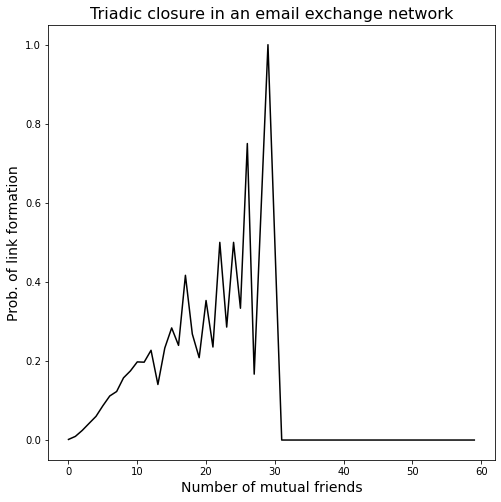

In [16]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Number of mutual friends', size = 14)
ax.set_ylabel('Prob. of link formation', size = 14)
ax.set_title('Triadic closure in an email exchange network', size = 16)

ax.plot(k, tk, color = 'black')

plt.show()

# Run the algorithm on the whole dataset using rolling basis

In [17]:
def kossinets_watts_rolling_average(data):
    # the rolling use a period of 100 days (1 day = 86400 sec)
    max_t = math.floor(max(data['timestamp']) / (86400*100))
    # however, after exploring the data, it does not seem relevant after t = 5
    max_t = 5
    # get 100 days value
    day_100 = 86400*100
    # initiate df to store data
    df = pd.DataFrame()
    data[data['timestamp'] < 8640000]
    for t in tqdm(range(max_t-1)):
        snap1 = data[data['timestamp'] < (t+1)*day_100]
        # sort by source, target
        snap1.sort_values(by = ['source', 'target'], ascending = True, inplace = True)

        snap2 = data[data['timestamp'] < (t+2)*day_100]
        # sort by source, target
        snap2.sort_values(by = ['source', 'target'], ascending = True, inplace = True)
    
        snap1_result, snap1_structure = kossinets_watts(snap1)
        snap2_result, snap2_structure = kossinets_watts(snap2)
        
        new_tie_formed = get_added_ties(snap1_structure, snap2_structure)
        
        # get prob
        total_prob = {}
        # get total of nodes by mutual ties
        for node in snap1_result:
            for mutual in snap1_result[node]:
                num_node = len(snap1_result[node][mutual])
                if mutual in total_prob.keys():
                    total_prob[mutual] = total_prob[mutual] + num_node
                else:
                    total_prob[mutual] = num_node

        edge_form_prob = {}
        for node in new_tie_formed:
            for tie in new_tie_formed[node]:
                for k in snap1_result[node]:
                    if tie in snap1_result[node][k]:
                        if k in edge_form_prob.keys():
                            edge_form_prob[k] = edge_form_prob[k] + 1
                        else:
                            edge_form_prob[k] = 1
        
        # get k-t(k) dict for visualization
        k_tk_dict = {}
        for k in sorted(total_prob.keys()):
            if k not in edge_form_prob.keys():
                edge_form_prob[k] = 0
            k_tk_dict[k] = edge_form_prob[k] / total_prob[k]
        temp_df = pd.DataFrame.from_dict(k_tk_dict, orient='index', columns = ['tk'])
        # merge df
        df = pd.merge(df, temp_df, left_index = True, right_index = True, how = 'outer')
        df = pd.DataFrame(df.mean(axis = 1), columns = ['tk_bar'])
    return df

In [18]:
df = kossinets_watts_rolling_average(data)

In [19]:
df2 = df.rename_axis('k').reset_index()

In [20]:
# prep data for plot
# df = df.rename_axis('k').reset_index()
k = df2['k']
tk = df2['tk_bar']

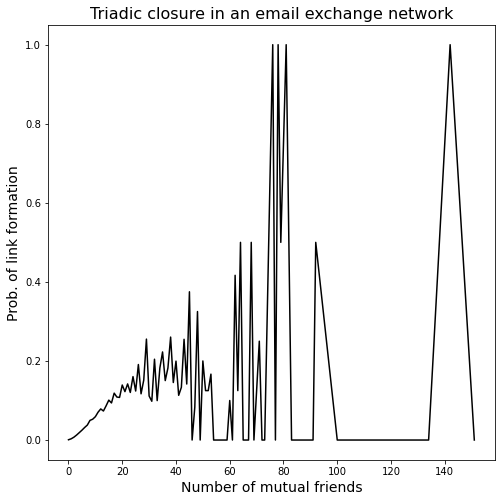

In [21]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Number of mutual friends', size = 14)
ax.set_ylabel('Prob. of link formation', size = 14)
ax.set_title('Triadic closure in an email exchange network', size = 16)

ax.plot(k, tk, color = 'black')

plt.show()

In [22]:
df2 = df2.iloc[:40, :]

In [23]:
# prep data for plot
# df = df.rename_axis('k').reset_index()
k = df2['k']
tk = df2['tk_bar']

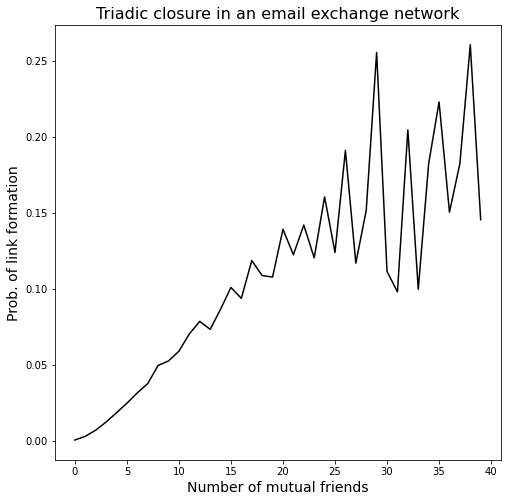

In [24]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Number of mutual friends', size = 14)
ax.set_ylabel('Prob. of link formation', size = 14)
ax.set_title('Triadic closure in an email exchange network', size = 16)

ax.plot(k, tk, color = 'black')

plt.show()